In [325]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import time
from collections import defaultdict

In [326]:
Htest = 142 #forecast horizon for testset
train_val_size = 532

k = train_val_size
H = 532

In [327]:
df = pd.read_csv('municipality_bus_utilization.csv')
df

timestamp  municipality_id  usage  total_capacity
0      2017-06-04 07:59:42                9    454            1332
1      2017-06-04 07:59:42                8    556            2947
2      2017-06-04 07:59:42                4   1090            3893
3      2017-06-04 07:59:42                0    204            2813
4      2017-06-04 07:59:42                7    718            2019
...                    ...              ...    ...             ...
13065  2017-08-19 16:30:35                2    548             697
13066  2017-08-19 16:30:35                8   1193            2947
13067  2017-08-19 16:30:35                7   1354            2019
13068  2017-08-19 16:30:35                6   1680            3113
13069  2017-08-19 16:30:35                3   1189            1930

[13070 rows x 4 columns]

# Exploratory Null Check

In [328]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [329]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
hour = df['hour'] = df['timestamp'].dt.hour
time = df['time'] = df['timestamp'].dt.date

# Split Dataset Into as Pre_Train and Pre_Test Sets

In [330]:
data = df.drop(['hour','time'], axis=1)

pre_traindata = data.iloc[:10390,:] # data.iloc[10390][0] = 2017-08-05 start point shown in problem book.
pre_testdata = data.iloc[10390:,:] # starting from 2017-08-05 to 2017-08-19 2 weeks.

pre_traindata = pre_traindata.sort_values(["municipality_id","timestamp"], ascending = (True,True))
pre_testdata = pre_testdata.sort_values(["municipality_id","timestamp"], ascending = (True,True))

pre_traindata_var_holder = {}
pre_testdata_var_holder = {}
for i in range(10):
    grouped = pre_traindata.groupby(pre_traindata.municipality_id)
    pre_traindata_var_holder['pre_traindata' + str(i)] = grouped.get_group(i)
    grouped = pre_testdata.groupby(pre_testdata.municipality_id)
    pre_testdata_var_holder['pre_testdata' + str(i)] = grouped.get_group(i)
locals().update(pre_traindata_var_holder) # after all of the "variables" created, update them to the locals "dictionary"(symbol table).
locals().update(pre_testdata_var_holder)

# Prepare Training Data Set

In [331]:
traindata_holder = {}
train_time_data_holder = {}

for i in range(10):
    traindata_holder['traindata' + str(i)] = pre_traindata_var_holder['pre_traindata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
    train_time_data_holder['train_time_data' + str(i)] = pre_traindata_var_holder['pre_traindata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
locals().update(traindata_holder)
locals().update(train_time_data_holder)

# Prepare Test Data Set

In [332]:
testdata_holder = {}
test_time_data_holder = {}
for i in range(10):
    testdata_holder['testdata' + str(i)] = pre_testdata_var_holder['pre_testdata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
    test_time_data_holder['test_time_data' + str(i)] = pre_testdata_var_holder['pre_testdata' + str(i)].groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
locals().update(testdata_holder)
locals().update(test_time_data_holder)

# General functions for Single Exponential Smoothing mape, mae, rmse, single_exponential_smoothing

In [334]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def single_exponential_smoothing(series, H, alpha=0.5):
    """
    Given a series and alpha, return series of smoothed points
    Set S_2 = y_1 (there is no S_1), and
    S_t = alpha * y_t-1 + (1-alpha) * S_t-1, where t >= 3. Note t starts from 1.
    Forecast S_t+1 = alpha * y_origin + (1-alpha) * S_t, where y_origin is the last known data point    
    Inputs
        series: series to forecast
        alpha : smoothing constant. 
                When alpha is close to 1, dampening is quick. 
                When alpha is close to 0, dampening is slow
        H : forecast horizon for test set
    Outputs
        result: the predictions. The length of result is H
    """
    result = [0, series[0]] # initialization
    for n in range(1, len(series)+H-1):
        if n >= len(series): # we are forecasting
            result.append(alpha * series[-1] + (1 - alpha) * result[n])
        else:
            result.append(alpha * series[n] + (1 - alpha) * result[n]) 
            # result[2] is the forecast using series[1],  ie. result[2] is the estimate of series[2]
    return result[len(series):len(series)+H]

def double_exponential_smoothing(series, H, alpha, beta, return_all=False):
    """
    Given a series and alpha, return series of smoothed points
    Initialization: 
    S_1 = y_1, 
    b_1 = y_2 - y_1, 
    F_1 = 0, F_2 = y_1
    level, S_t = alpha*y_t + (1-alpha)*(S_t-1 + b_t-1)
    trend, b_t = beta*(S_t - S_t-1) + (1-beta)*b_t-1
    forecast, F_t+1 = S_t + b_t
    forecast, F_t+m = S_t + m*b_t
    result[len(series)] is the estimate of series[len(series)]
    Inputs
        series: series to forecast
        H     : forecast horizon
        alpha : smoothing constant. 
                When alpha is close to 1, dampening is quick. 
                When alpha is close to 0, dampening is slow
        beta  : smoothing constant for trend
        return_all : if 1 return both original series + predictions, if 0 return predictions only
    Outputs
        the predictions of length H
    """
    result = [0, series[0]]   
    level = series[0]
    trend = [series[1] - series[0]]
    for n in range(1, len(series)+H-1):            
        if n >= len(series): # we are forecasting
            m = n - len(series) + 2
            result.append(level + m*trend[-1]) # result[len(series)+1] is the estimate of series[len(series)+1]
        else:
            value = series[n]
            last_level = level
            level = alpha*value + (1-alpha)*(last_level+trend[n-1])
            trend.append(beta*(level-last_level) + (1-beta)*trend[n-1])
            result.append(level+trend[n]) 
            # e.g. result[2] uses series[1] 
            # ie. result[2] is the estimate of series[2]
            # e.g. result[len(series)] uses series[len(series)-1] 
            # ie. result[len(series)] is the estimate of series[len(series)]
    
#    if return_all == True:
#        return result, trend
#    else:
    return result[len(series):len(series)+H], trend

### Plot Train and Test Data

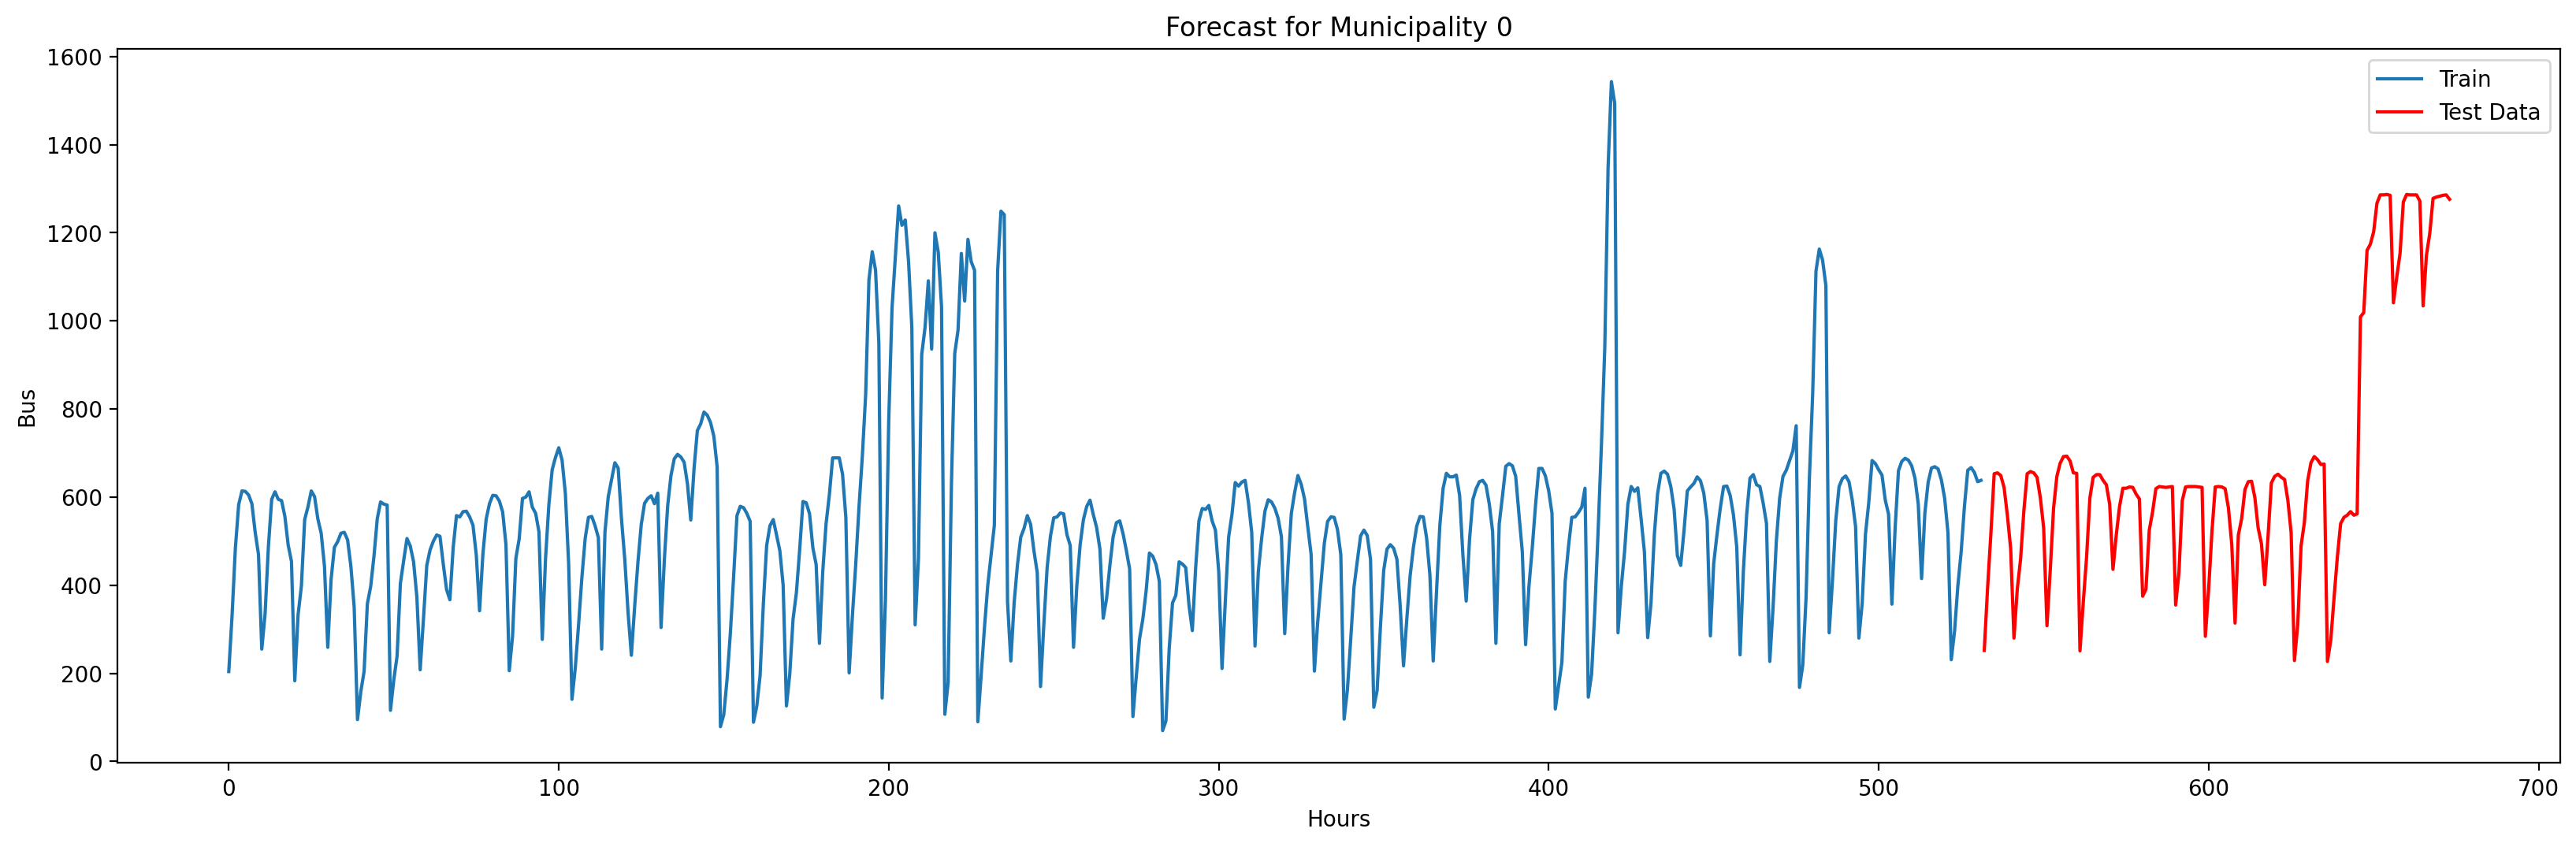

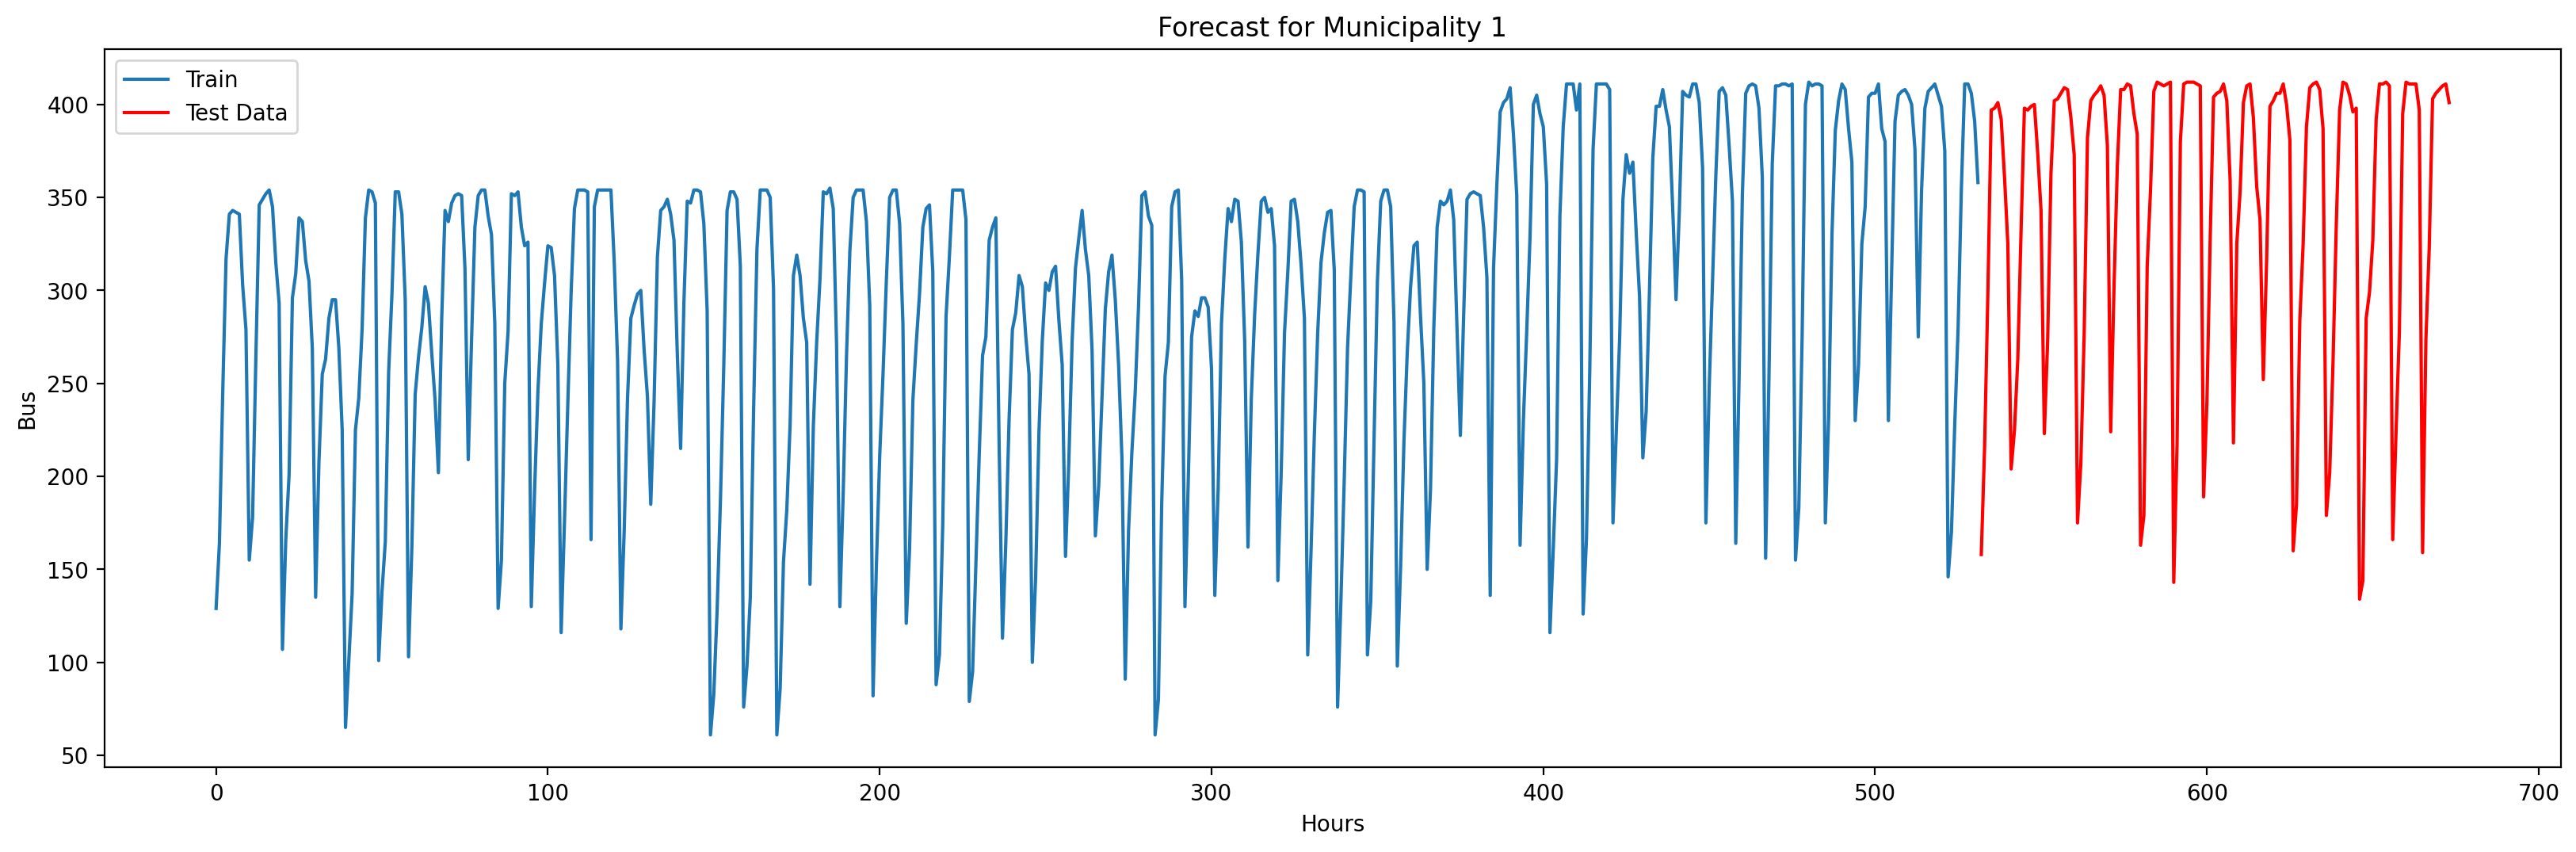

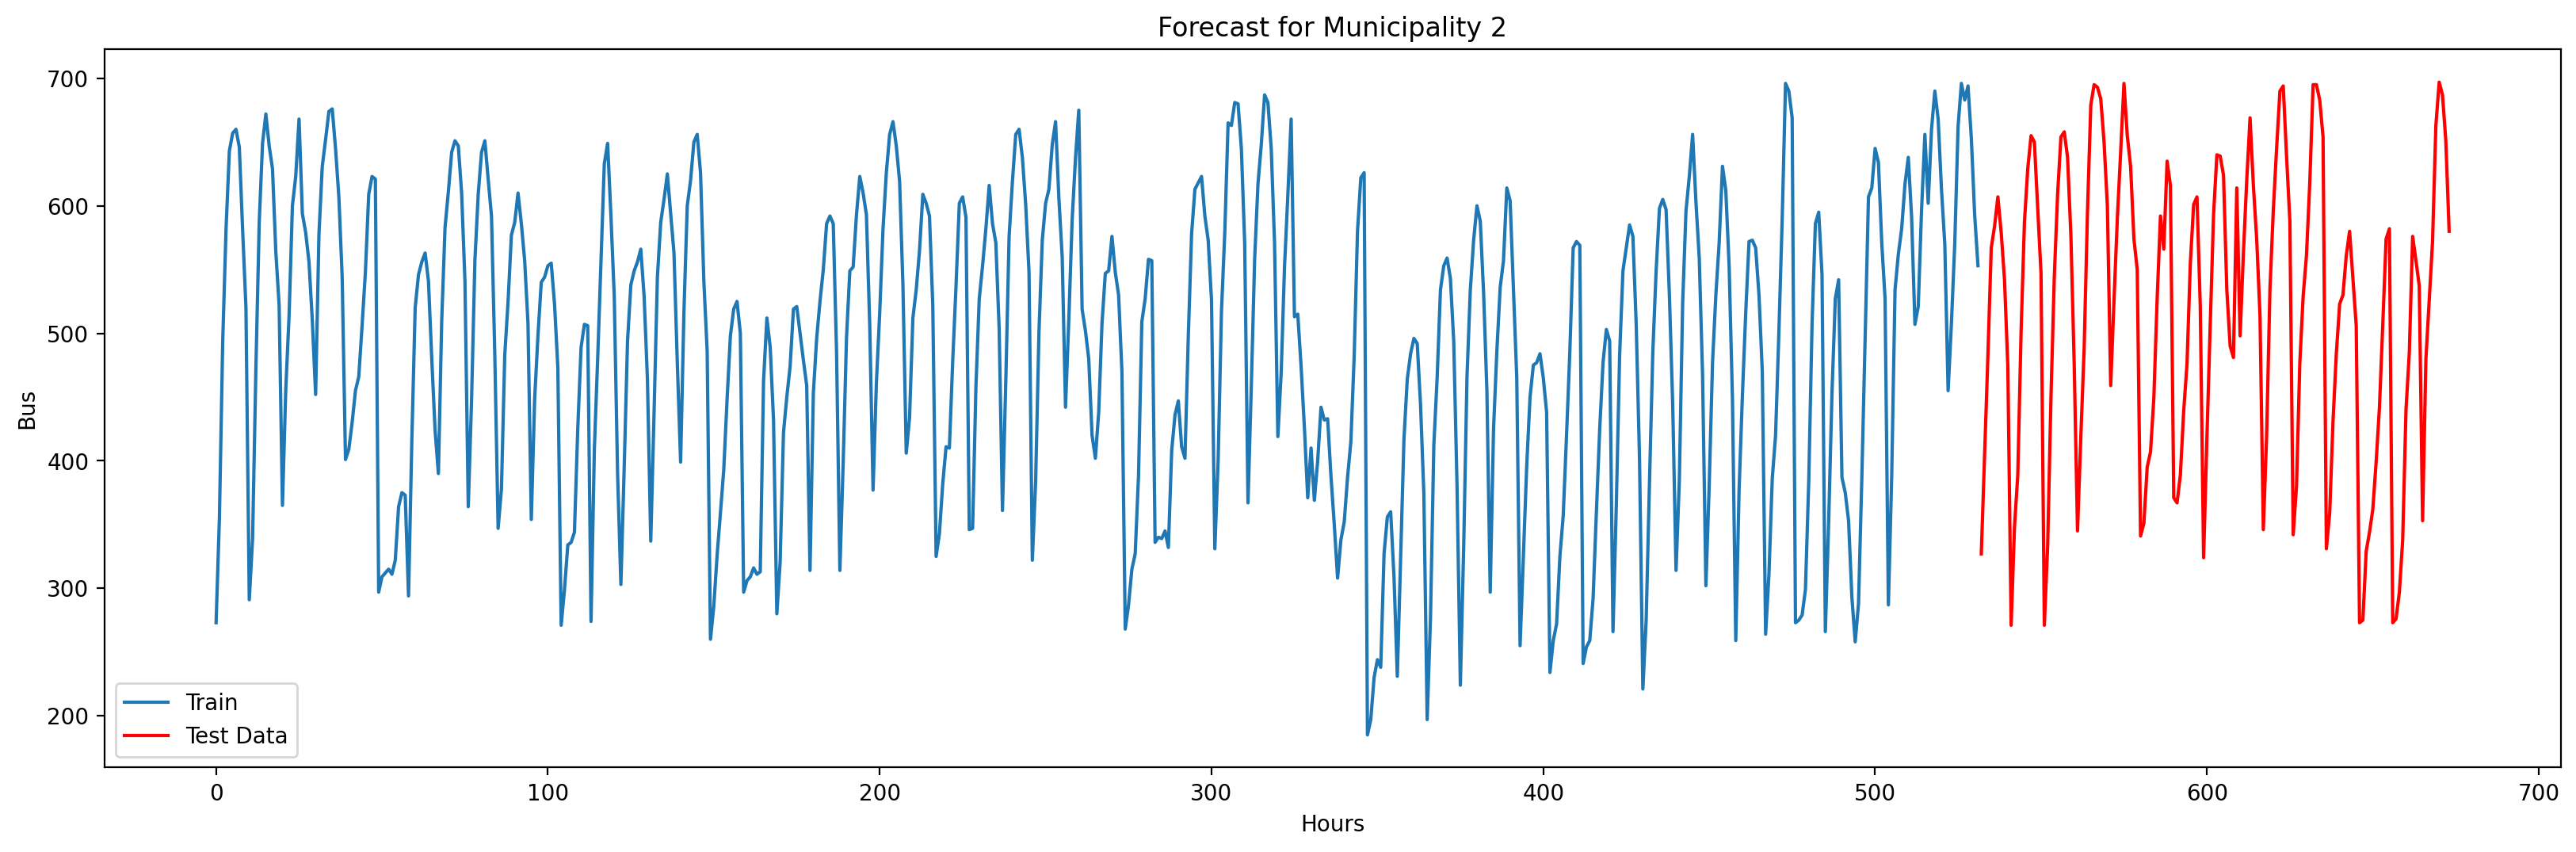

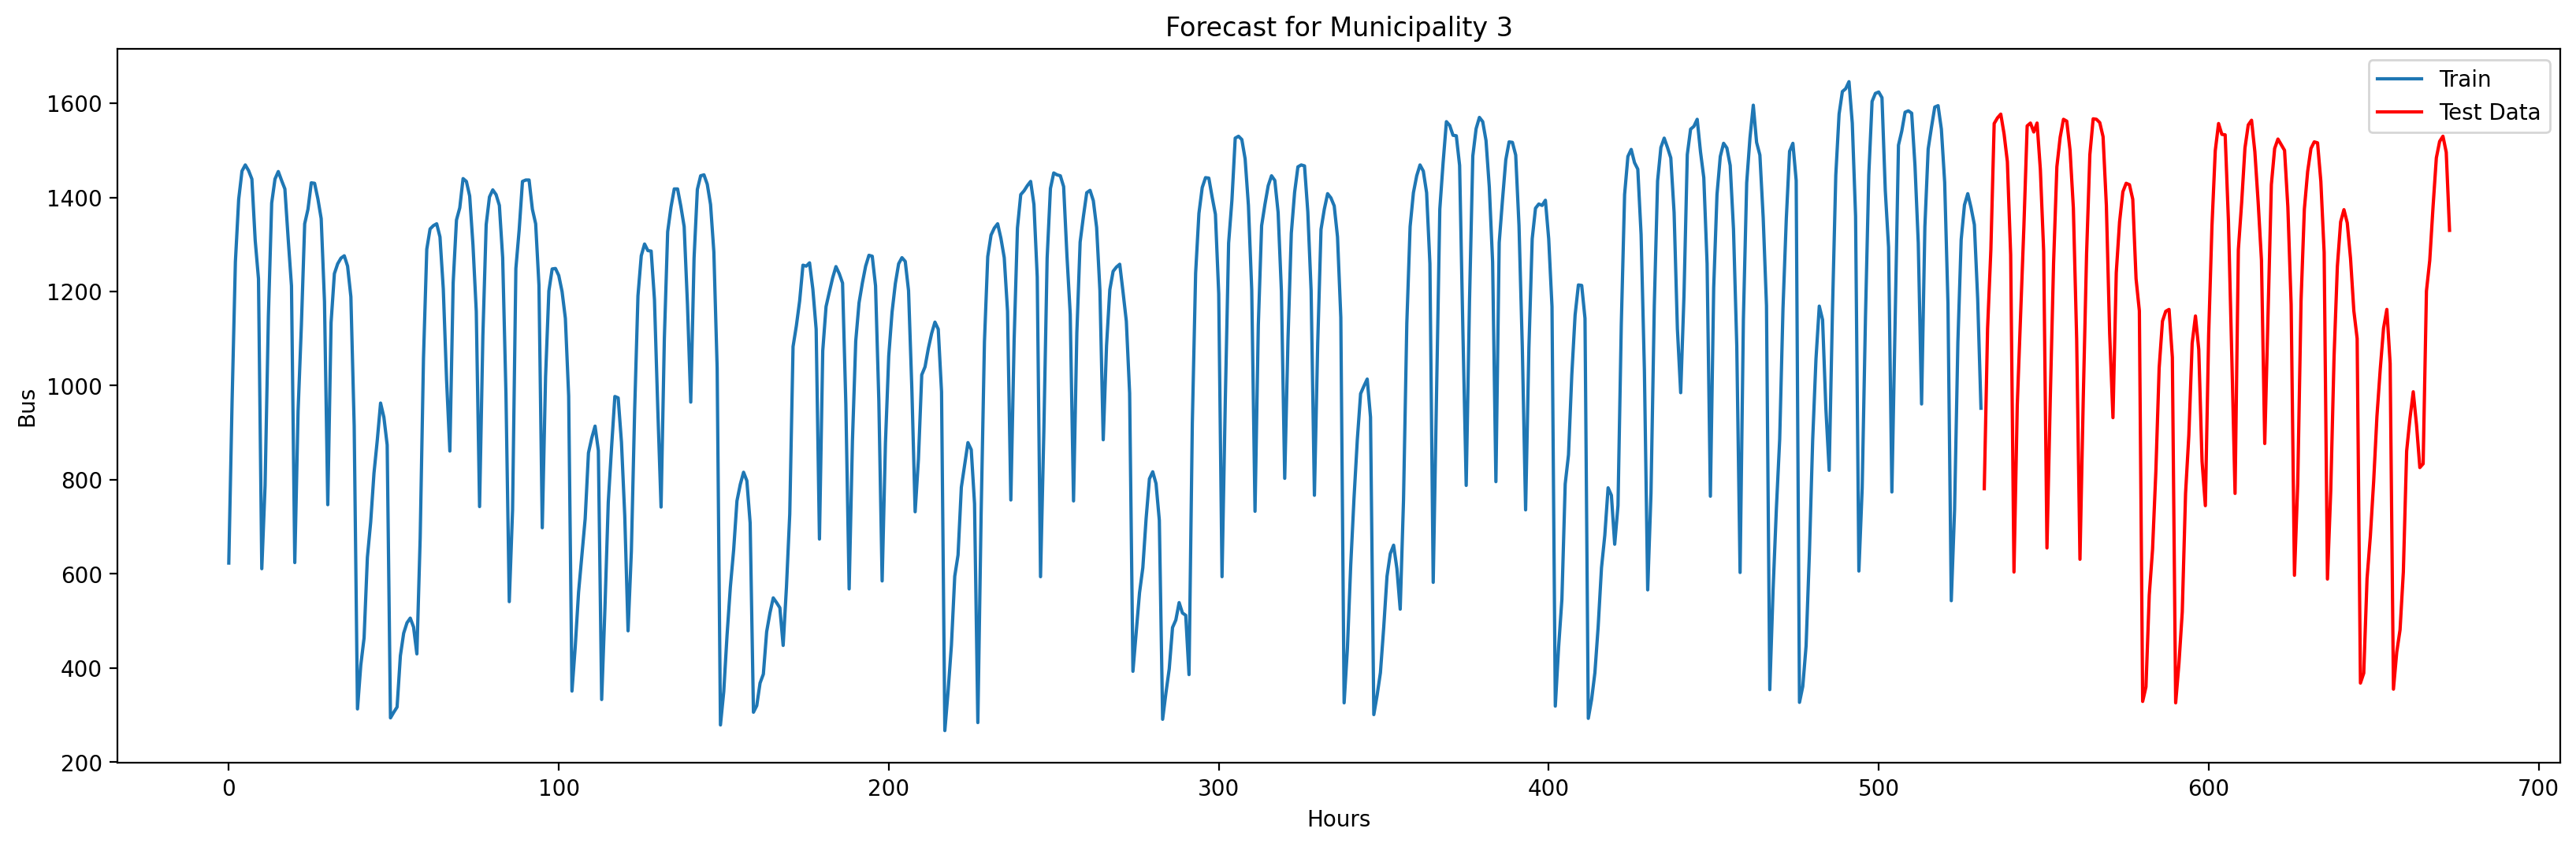

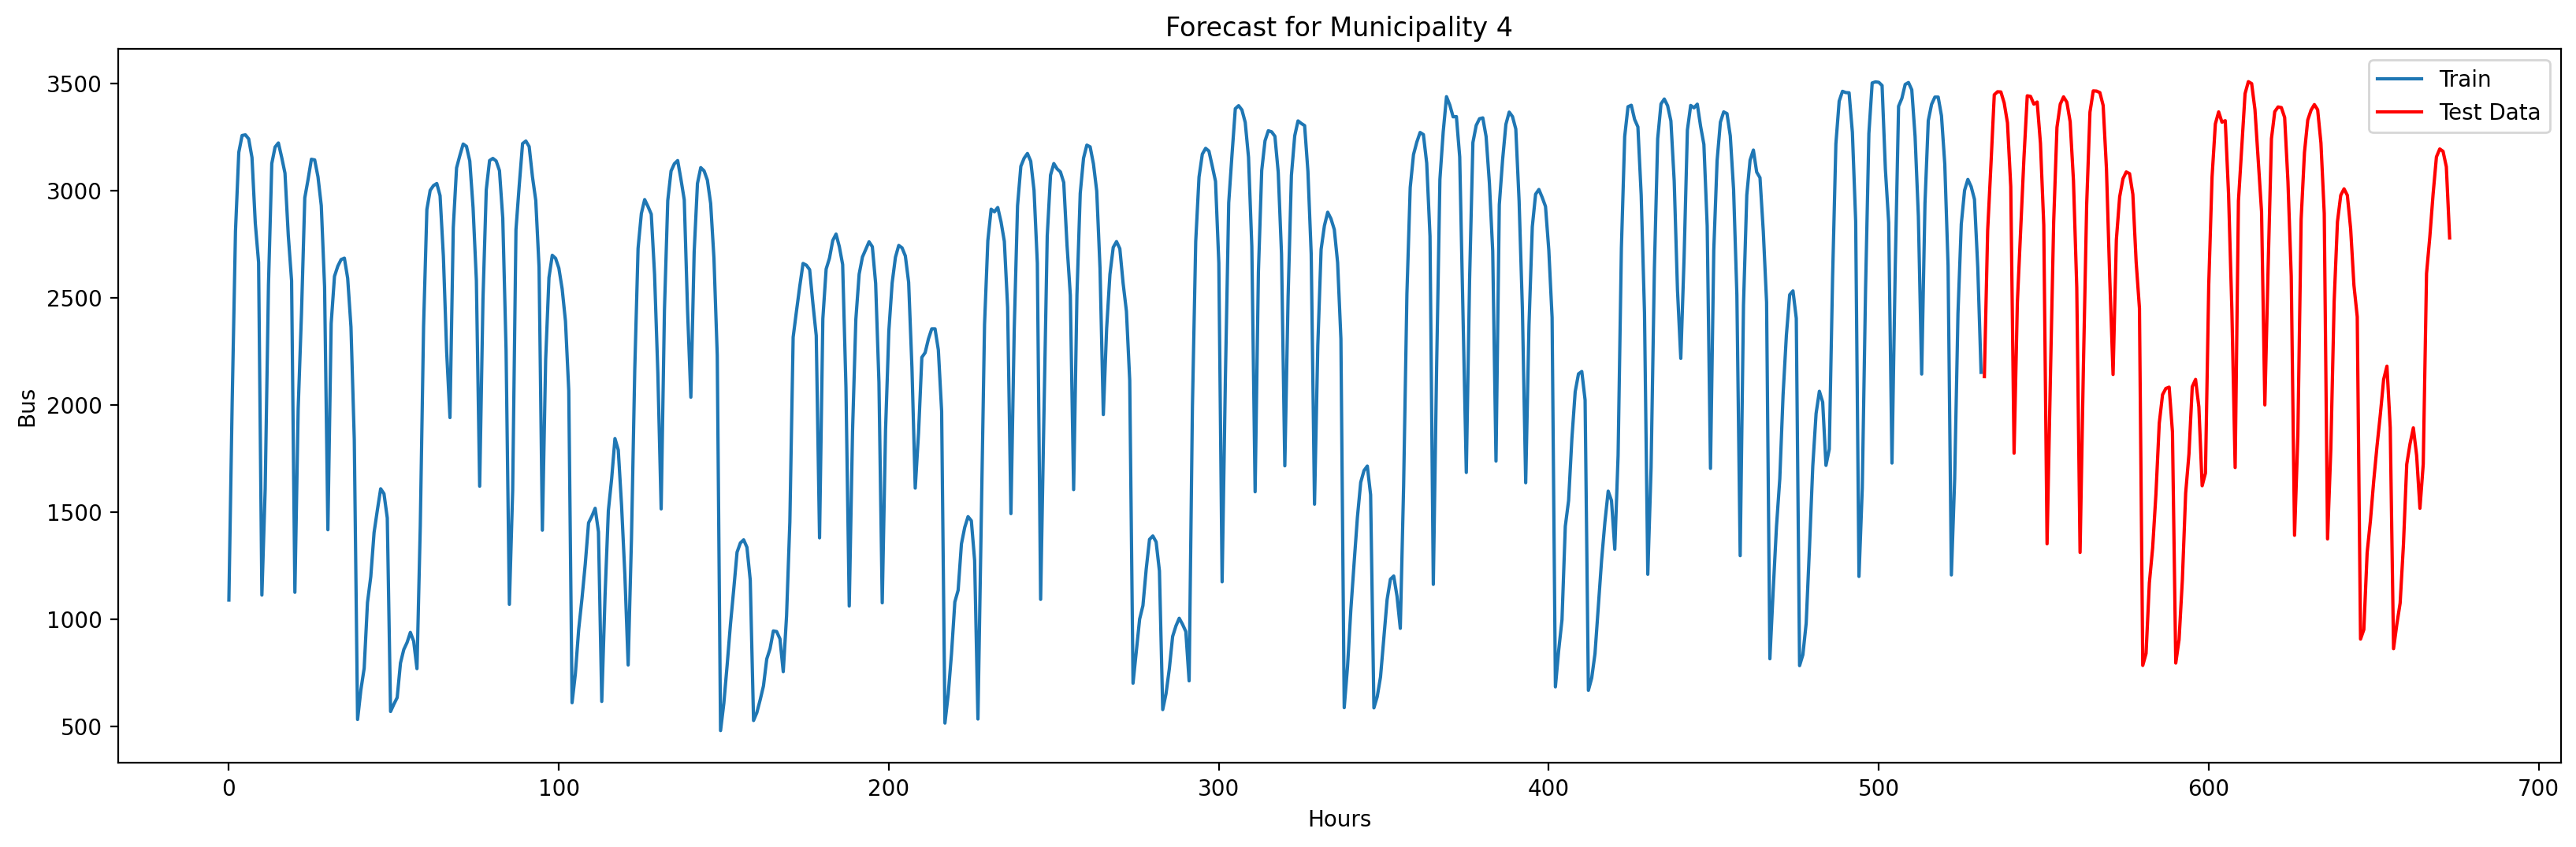

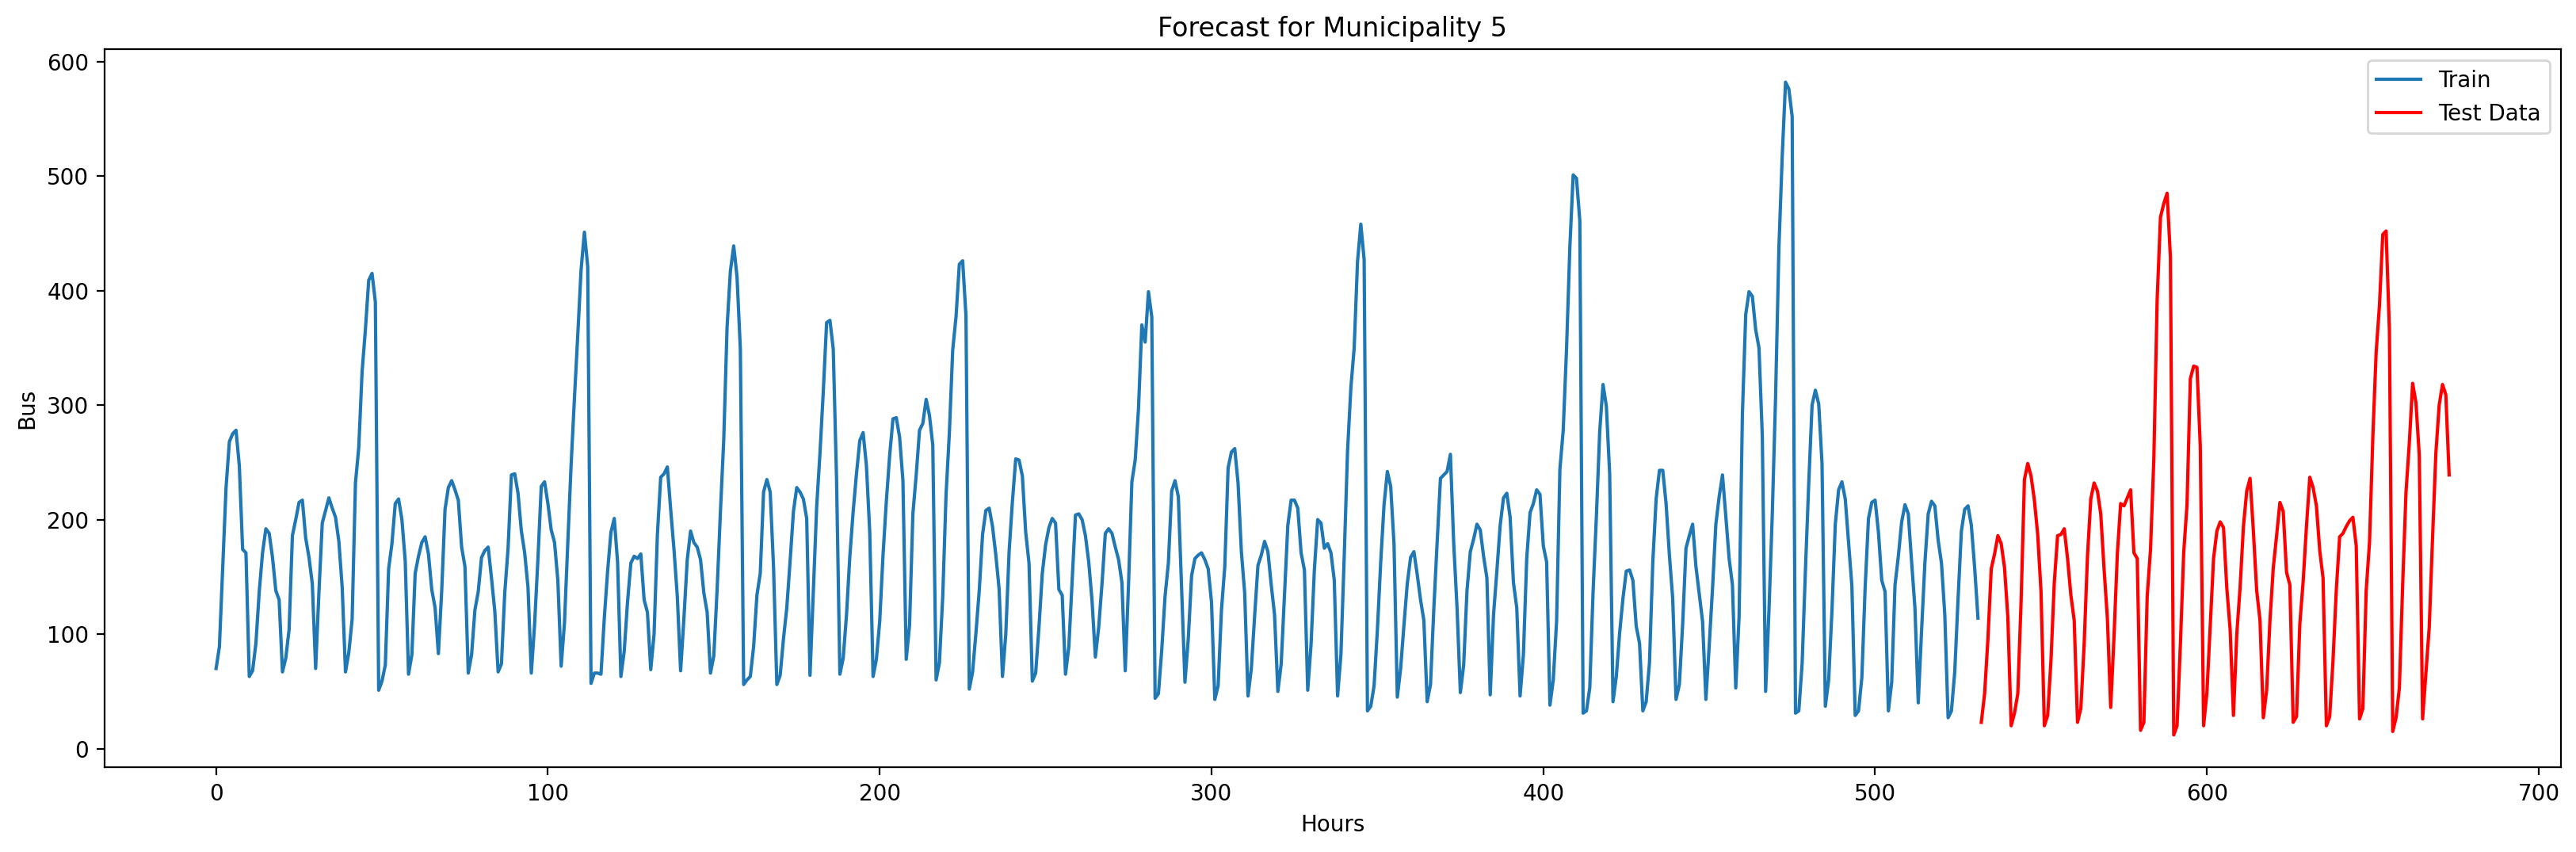

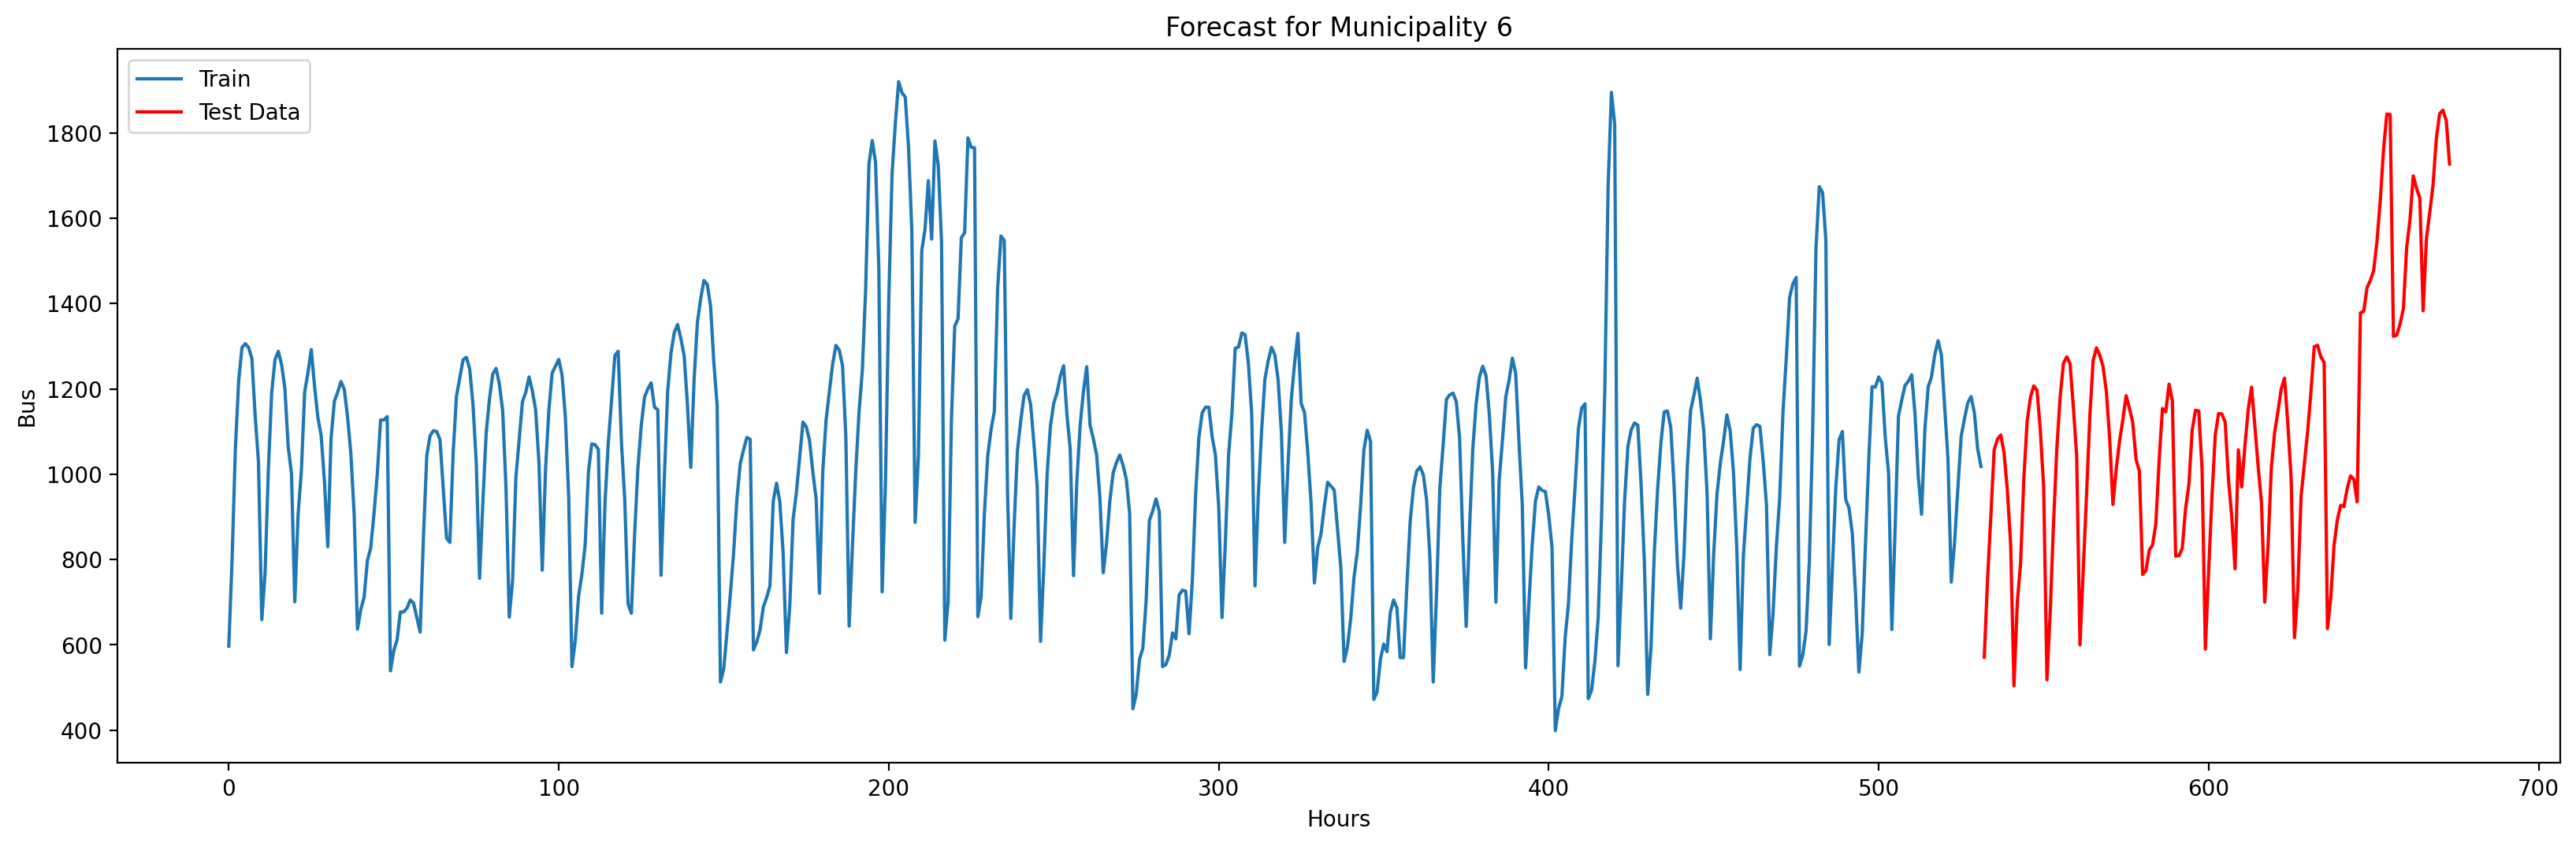

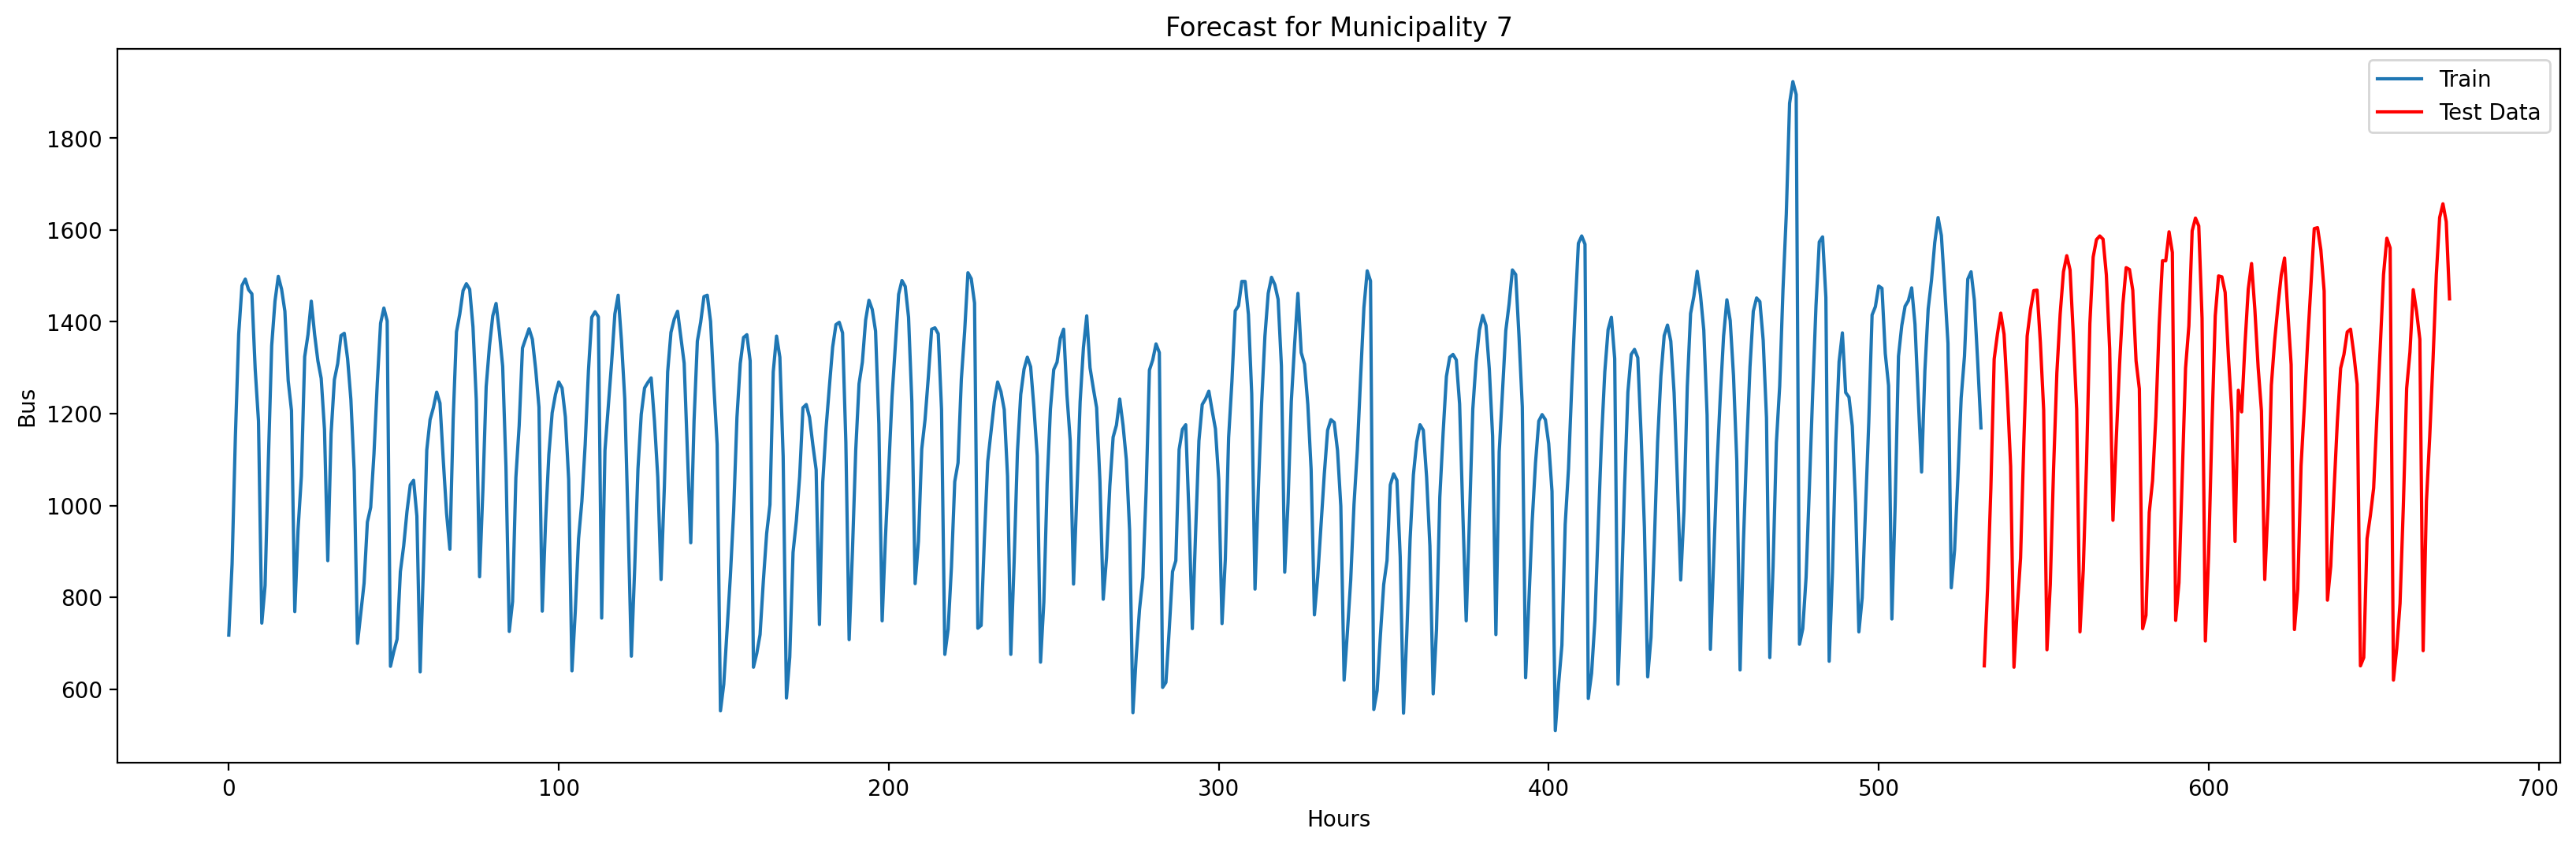

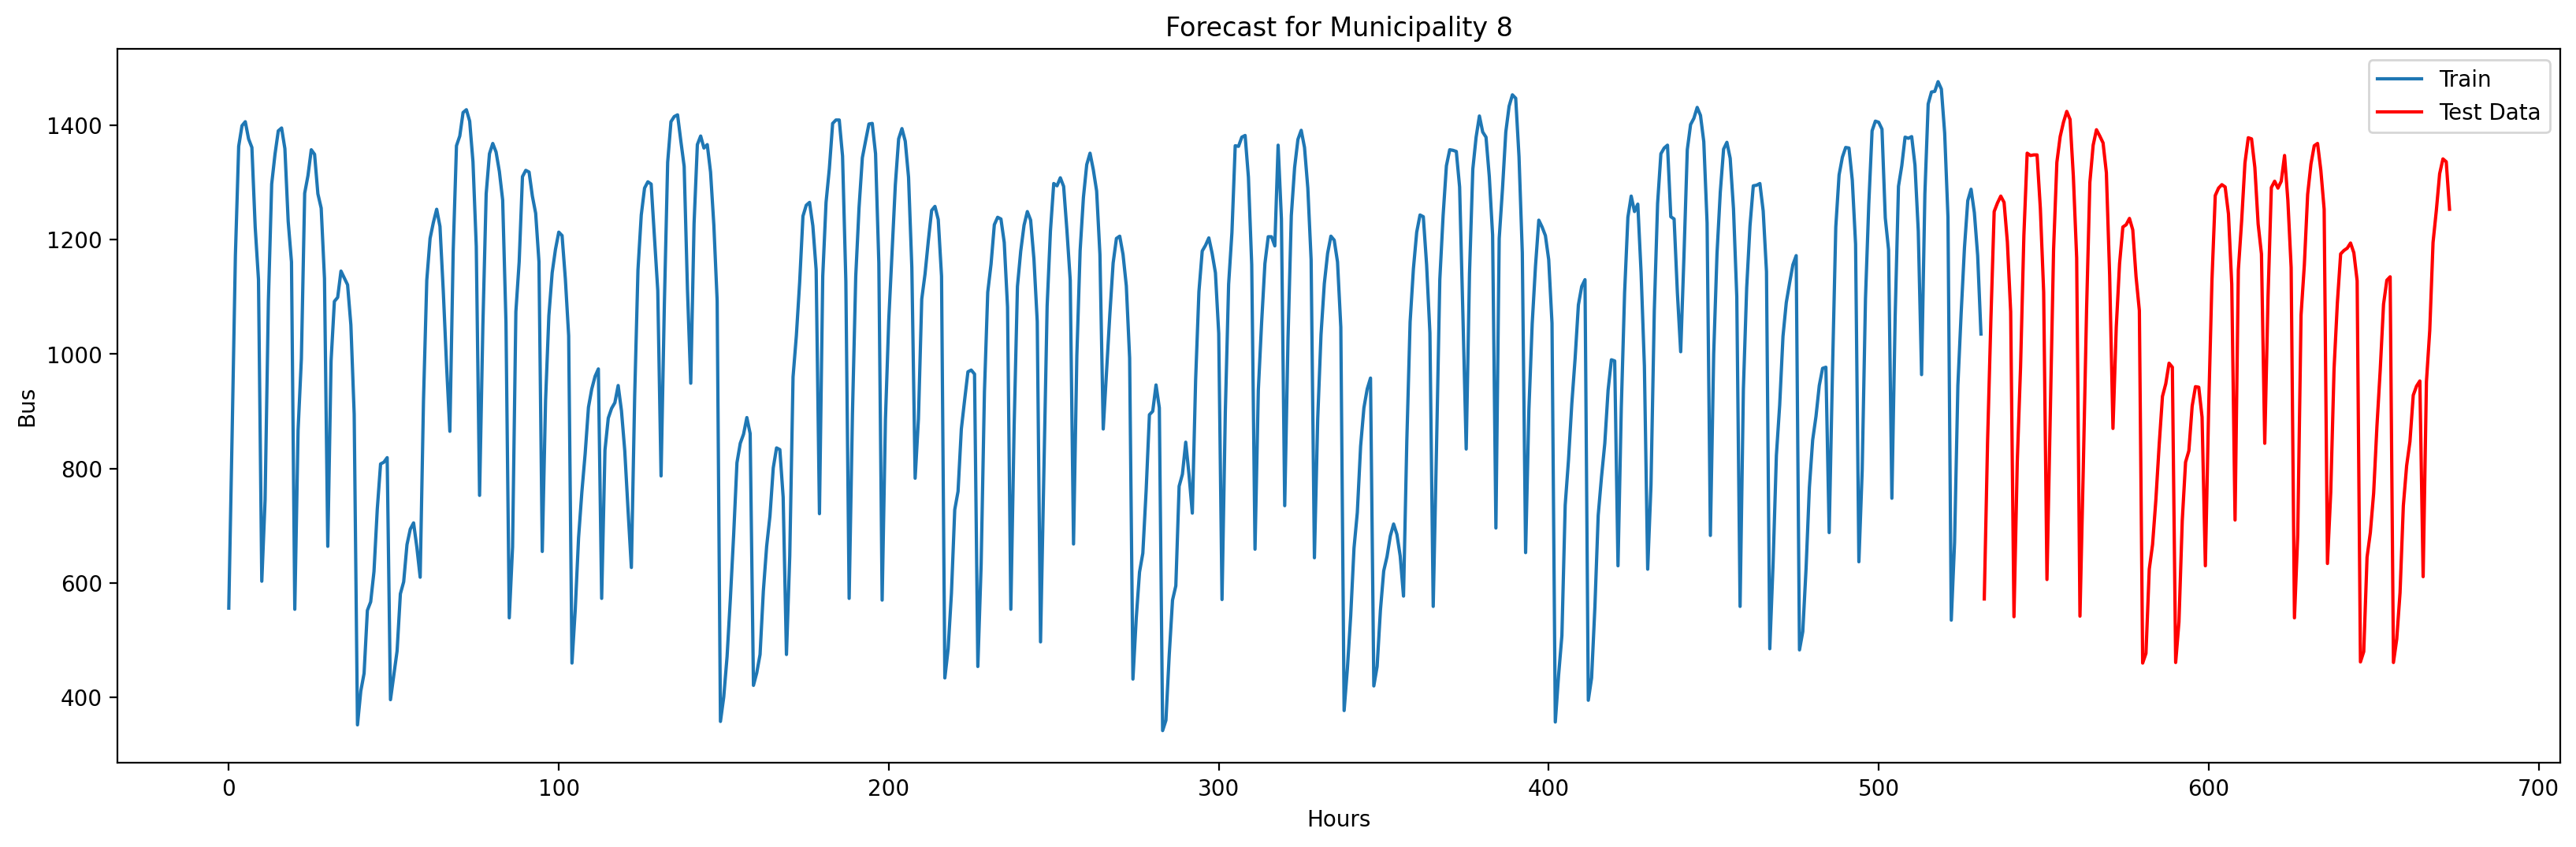

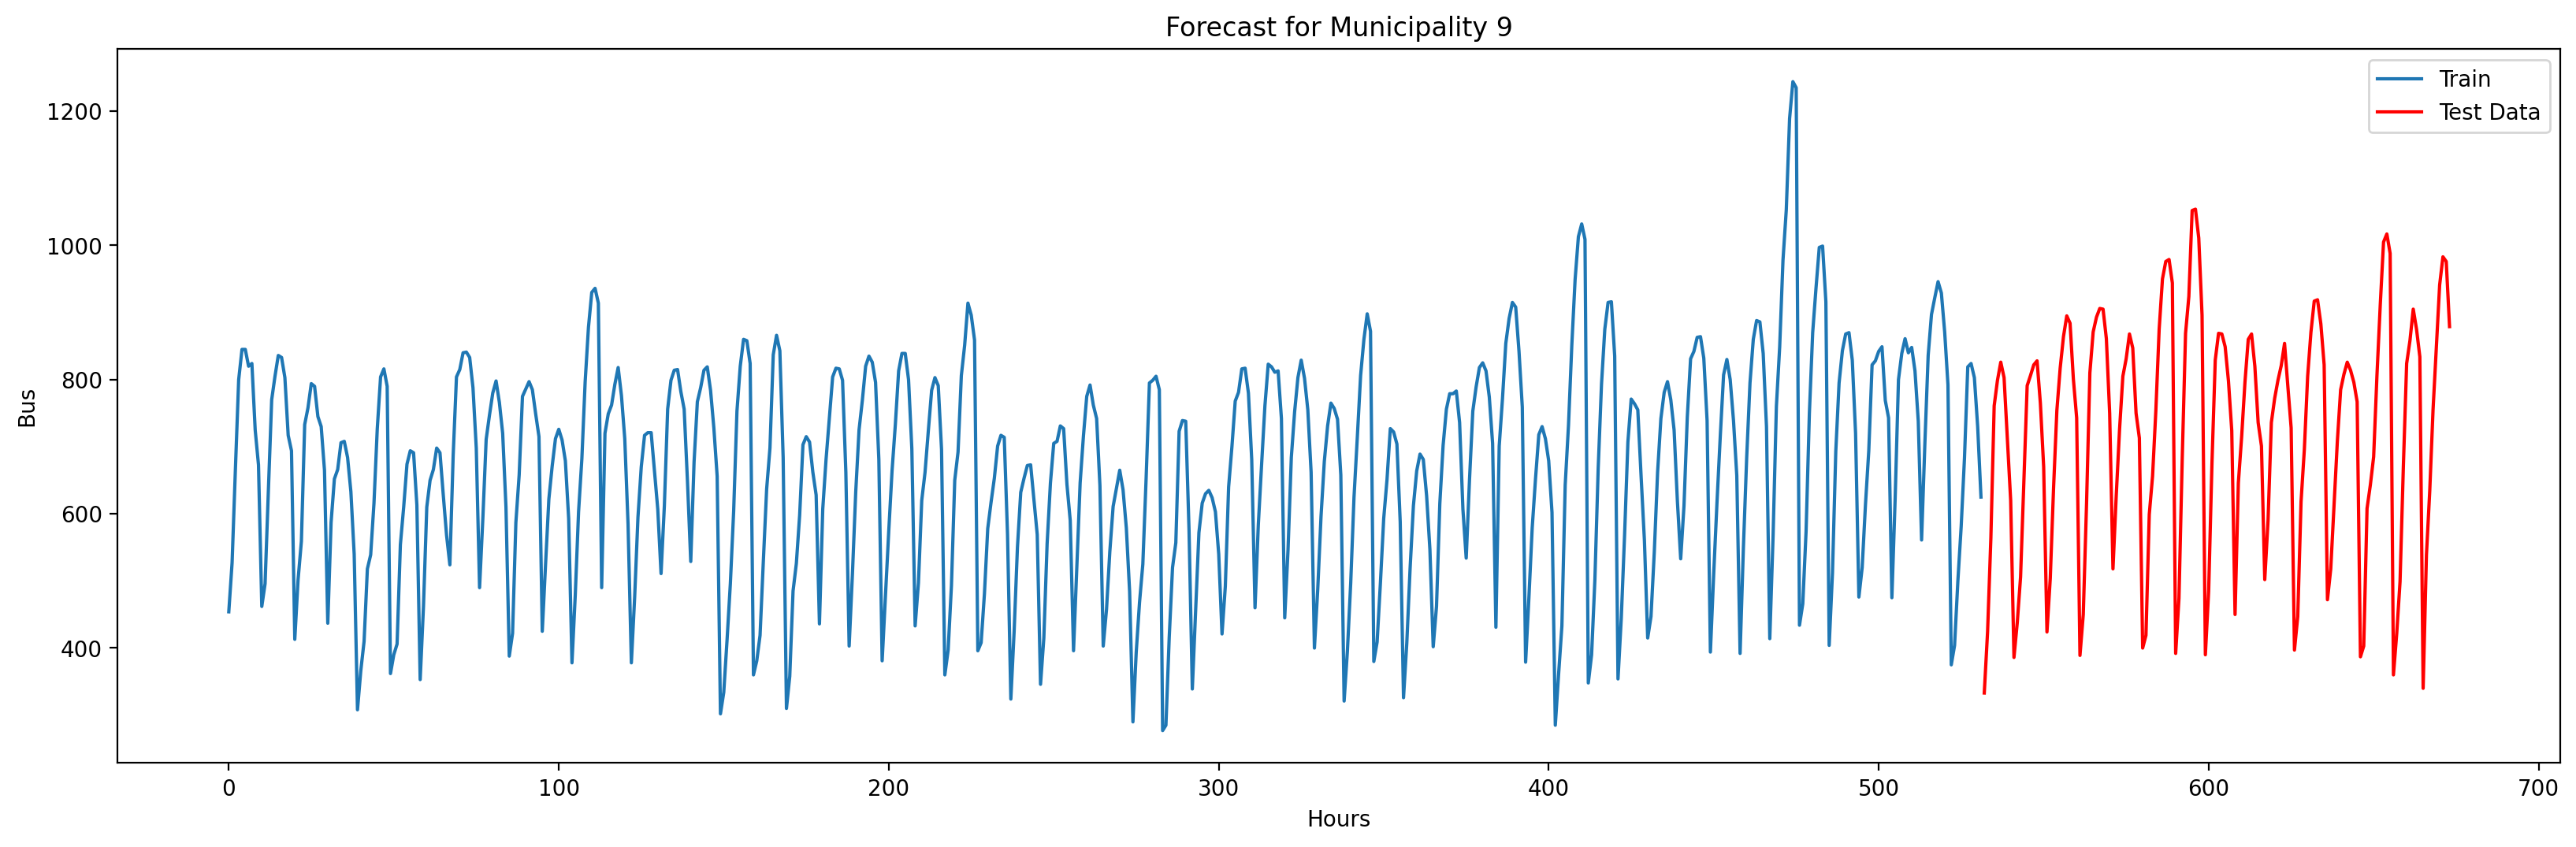

In [335]:

for i in range(10):
    testdata_holder['testdata' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(traindata_holder['traindata' + str(i)]["usage"].index, traindata_holder['traindata' + str(i)]["usage"], label='Train')
    plt.plot(testdata_holder['testdata' + str(i)]["usage"].index, testdata_holder['testdata' + str(i)]["usage"], 'r-', label = 'Test Data')
    plt.xlabel('Hours'); plt.ylabel('Bus'); plt.title('Forecast for Municipality %d' %i)
    plt.legend(loc="best")


### The dataset has no obvious trend or seasonal component.

In [336]:
print("Prediction starting for Municipality x , with single_exponential_smoothing method, with forecast horizon H = %d" % (Htest))

Prediction starting for Municipality x , with single_exponential_smoothing method, with forecast horizon H = 142


# Forecast Bus Usage for 10 municipalities with single_exponential_smoothing algorithm

####Training Set Prediction

In [337]:
single_prediction_holder = {}
for i in range(10):
    single_prediction_holder['single_prediction' + str(i)] = single_exponential_smoothing(traindata_holder['traindata' + str(i)]["usage"][k-train_val_size:k].values, H)

####Test Set Prediction

In [338]:
single_testprediction_holder = {}
for i in range(10):
    single_testprediction_holder['single_testprediction' + str(i)] = single_exponential_smoothing(testdata_holder['testdata' + str(i)]["usage"][0:Htest].values, Htest)

# Explore Training Set RMSE, mean MAPE and mean MAE for single_exponential_smoothing_algorithm

In [339]:
for i in range(10):
    print("For municipality %d, at forecast horizon %d, the RMSE is %f" % (i, H, get_rmse(traindata_holder['traindata' + str(i)][0:H]['usage'], single_prediction_holder['single_prediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAPE is %f" % (i, H, get_mape(traindata_holder['traindata' + str(i)][0:H]['usage'], single_prediction_holder['single_prediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAE is %f" % (i, H, get_mae(traindata_holder['traindata' + str(i)][0:H]['usage'], single_prediction_holder['single_prediction' + str(i)])))

For municipality 0, at forecast horizon 532, the RMSE is 246.695207
For municipality 0, at forecast horizon 532, the mean MAPE is 59.727785
For municipality 0, at forecast horizon 532, the mean MAE is 184.482310
For municipality 1, at forecast horizon 532, the RMSE is 109.462384
For municipality 1, at forecast horizon 532, the mean MAPE is 46.507952
For municipality 1, at forecast horizon 532, the mean MAE is 79.501889
For municipality 2, at forecast horizon 532, the RMSE is 136.377477
For municipality 2, at forecast horizon 532, the mean MAPE is 28.635585
For municipality 2, at forecast horizon 532, the mean MAE is 105.964046
For municipality 3, at forecast horizon 532, the RMSE is 390.056592
For municipality 3, at forecast horizon 532, the mean MAPE is 40.880021
For municipality 3, at forecast horizon 532, the mean MAE is 348.992447
For municipality 4, at forecast horizon 532, the RMSE is 891.418398
For municipality 4, at forecast horizon 532, the mean MAPE is 50.582505
For municipal

### Explore Test Set RMSE, mean MAPE and mean MAE for single_exponential_smoothing_algorithm

In [340]:
for i in range(10):
    print("For municipality %d, at forecast horizon %d, the RMSE is %f" % (i, Htest, get_rmse(testdata_holder['testdata' + str(i)][0:Htest]['usage'], single_testprediction_holder['single_testprediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAPE is %f" % (i, Htest, get_mape(testdata_holder['testdata' + str(i)][0:Htest]['usage'], single_testprediction_holder['single_testprediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAE is %f" % (i, Htest, get_mae(testdata_holder['testdata' + str(i)][0:Htest]['usage'], single_testprediction_holder['single_testprediction' + str(i)])))

For municipality 0, at forecast horizon 142, the RMSE is 660.345731
For municipality 0, at forecast horizon 142, the mean MAPE is 120.612361
For municipality 0, at forecast horizon 142, the mean MAE is 595.713703
For municipality 1, at forecast horizon 142, the RMSE is 98.261262
For municipality 1, at forecast horizon 142, the mean MAPE is 27.426479
For municipality 1, at forecast horizon 142, the mean MAE is 59.403844
For municipality 2, at forecast horizon 142, the RMSE is 133.881093
For municipality 2, at forecast horizon 142, the mean MAPE is 25.446336
For municipality 2, at forecast horizon 142, the mean MAE is 102.807642
For municipality 3, at forecast horizon 142, the RMSE is 391.898414
For municipality 3, at forecast horizon 142, the mean MAPE is 42.032507
For municipality 3, at forecast horizon 142, the mean MAE is 296.054474
For municipality 4, at forecast horizon 142, the RMSE is 834.150435
For municipality 4, at forecast horizon 142, the mean MAPE is 40.432316
For municipal

Obviously, all RMSE values are very large and that means our single_exponential_smoothing_algorithm can't do well on that problem. According to error results, I skip alpha optimization process and decided to switch to Holtwinters ExponentialSmoothing algorithm.

### Predict for a specific H (forecast horizon) and a specific date, with Holtwinters ExponentialSmoothing

In [341]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [342]:
for i in range(10):
    traindata_holder['traindata' + str(i)].reset_index(inplace=True)
    traindata_holder['traindata' + str(i)].drop(['index'], axis=1, inplace=True)
    
    testdata_holder['testdata' + str(i)].reset_index(inplace=True)
    testdata_holder['testdata' + str(i)].drop(['index'], axis=1, inplace=True)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    usage   No. Observations:                  532
Model:             ExponentialSmoothing   SSE                       14506696.400
Optimized:                         True   AIC                           5437.570
Trend:                             None   BIC                           5446.123
Seasonal:                          None   AICC                          5437.646
Seasonal Periods:                  None   Date:                 Thu, 22 Sep 2022
Box-Cox:                          False   Time:                         23:05:19
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              358.600

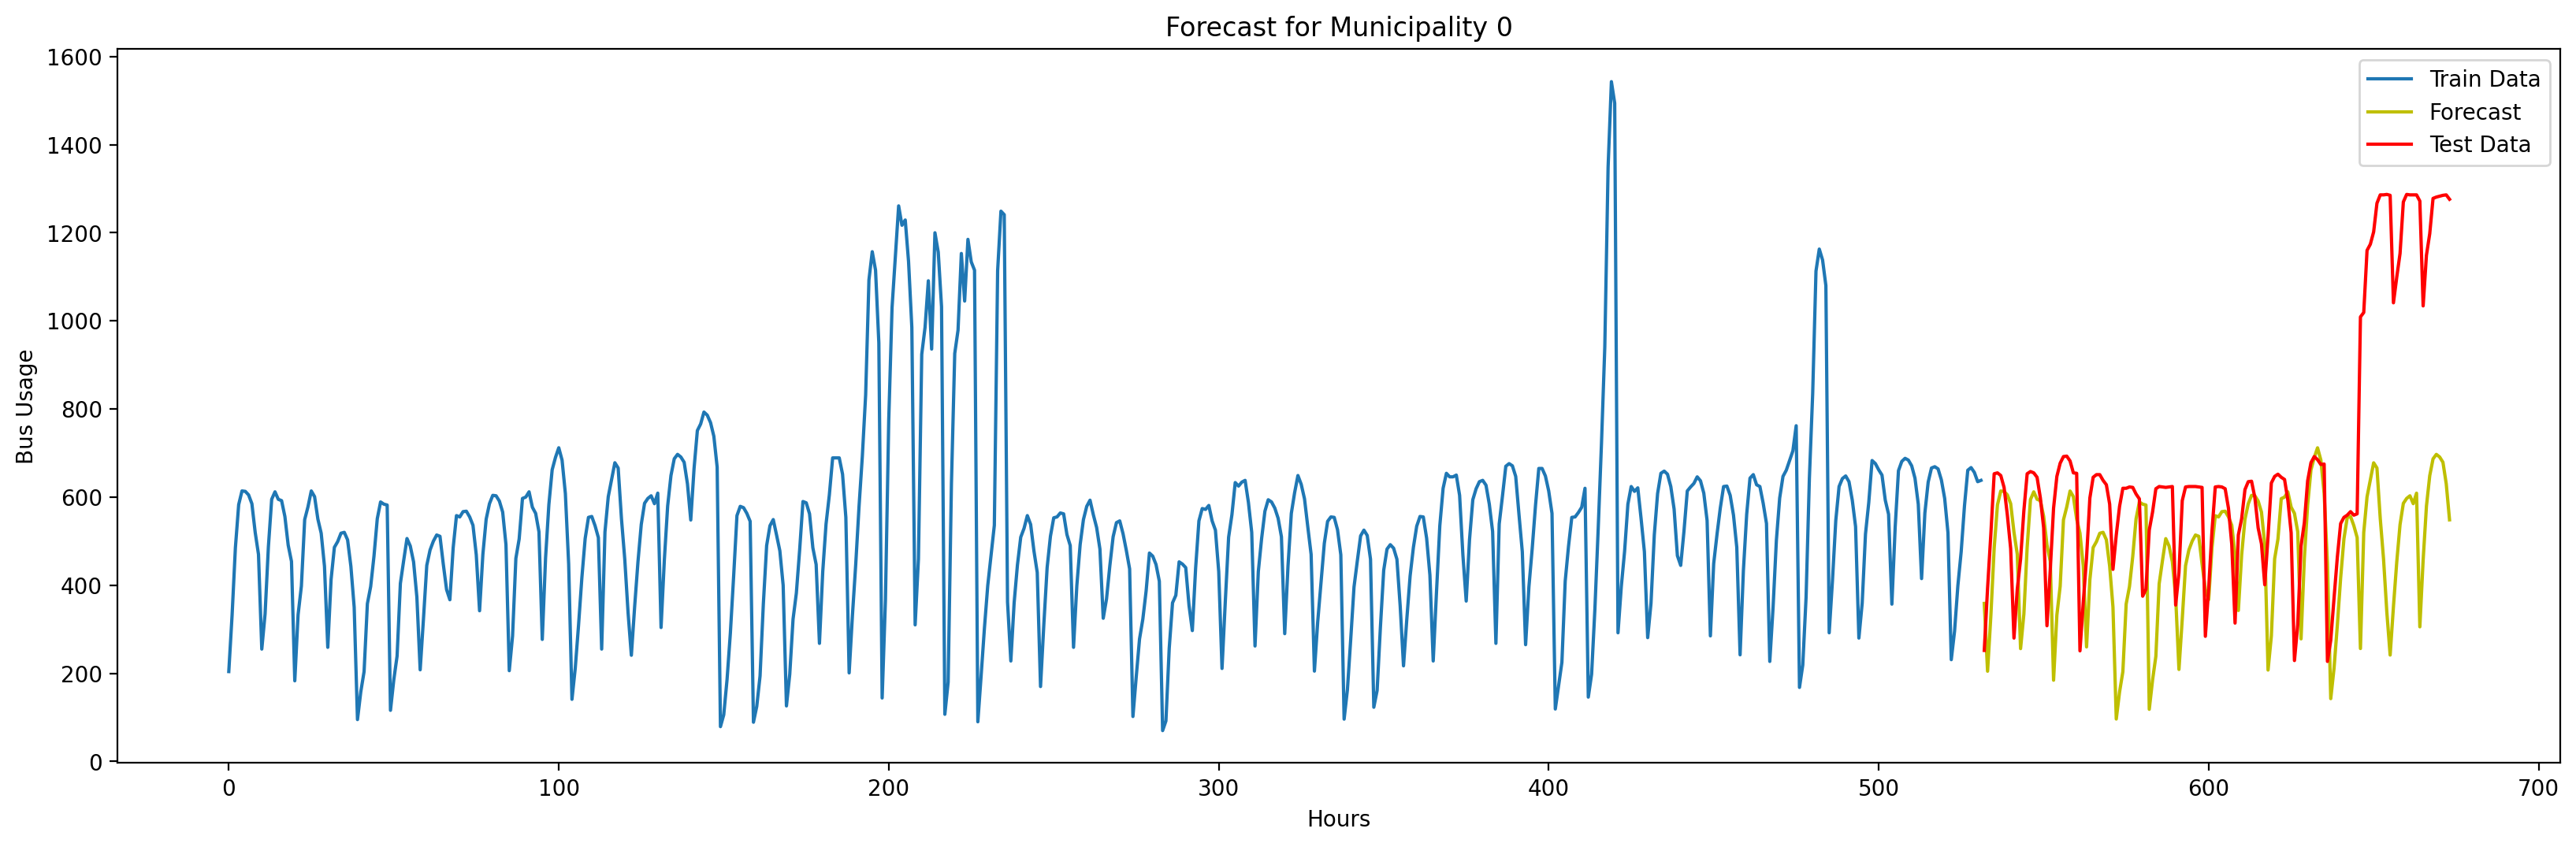

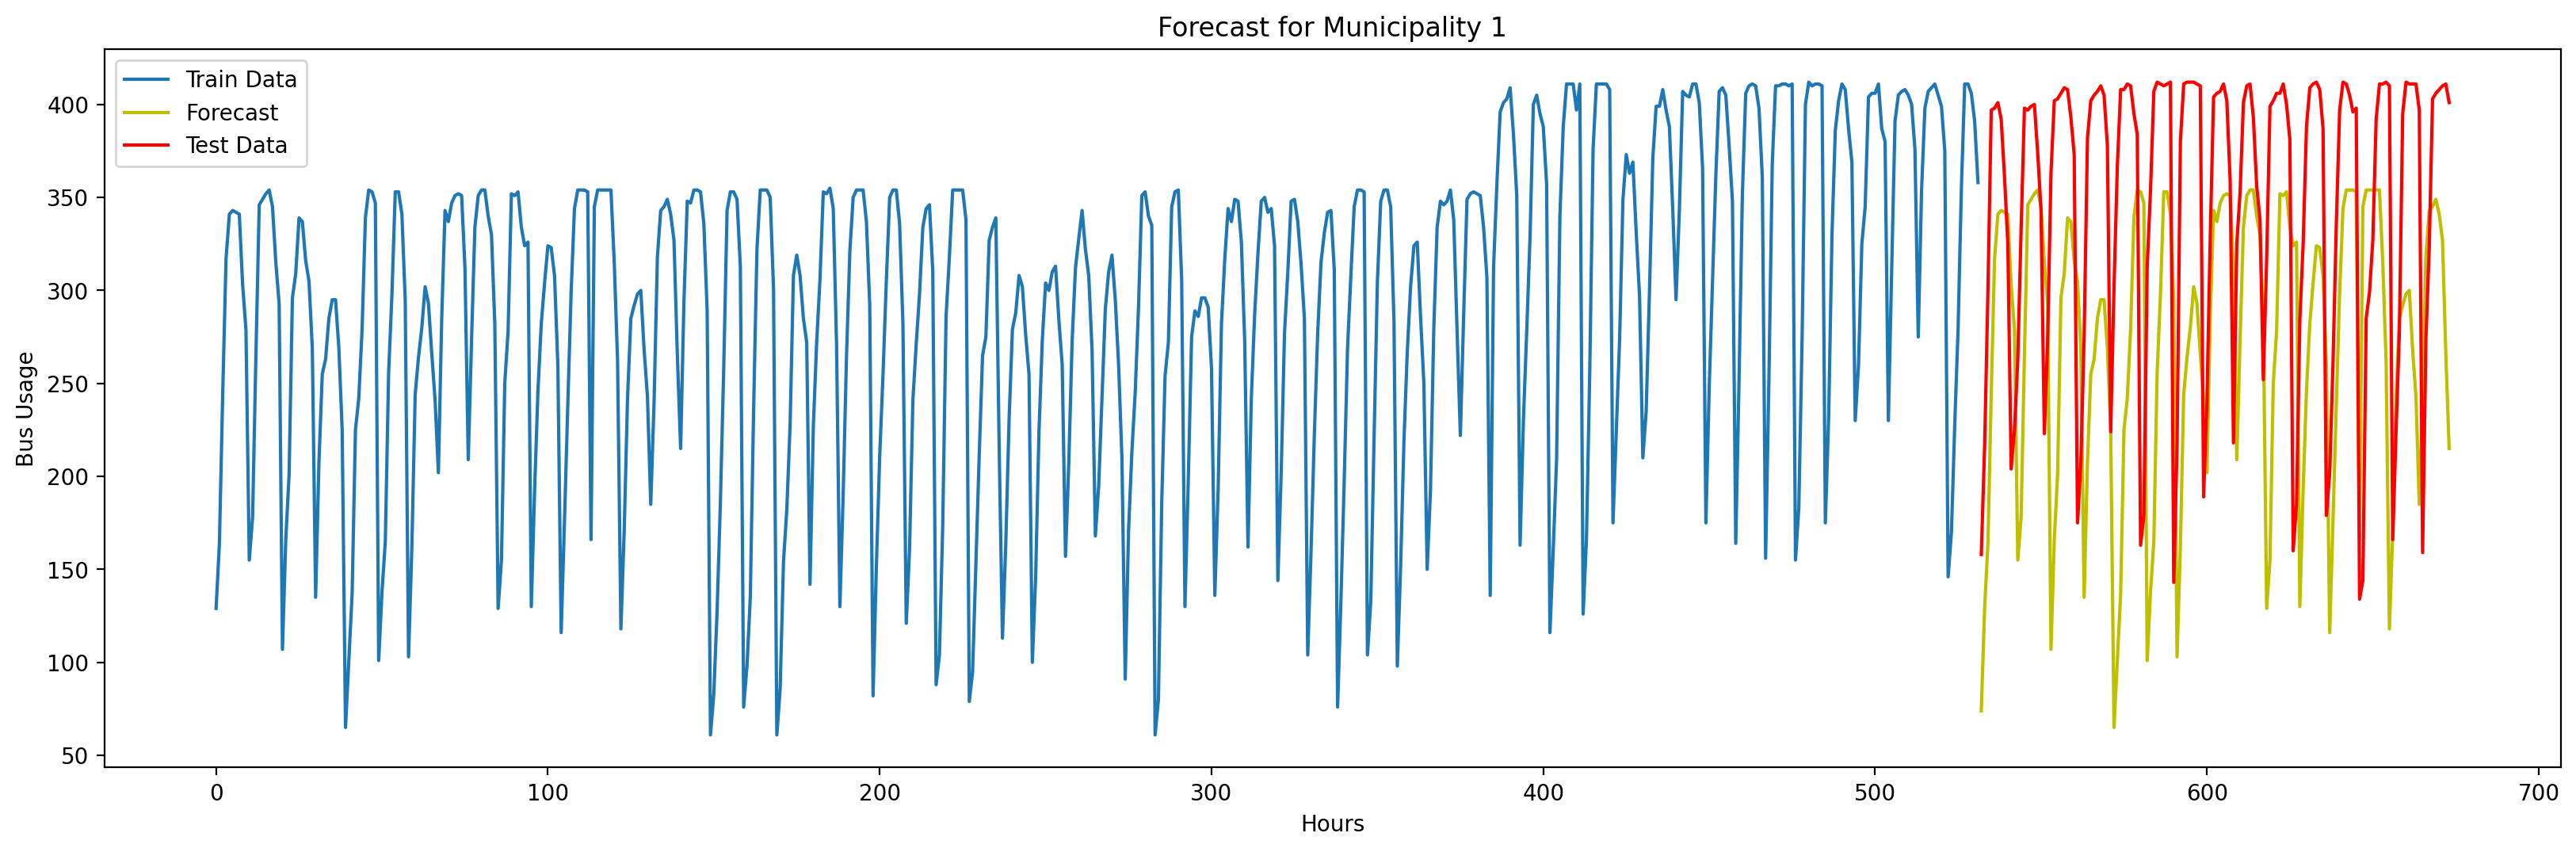

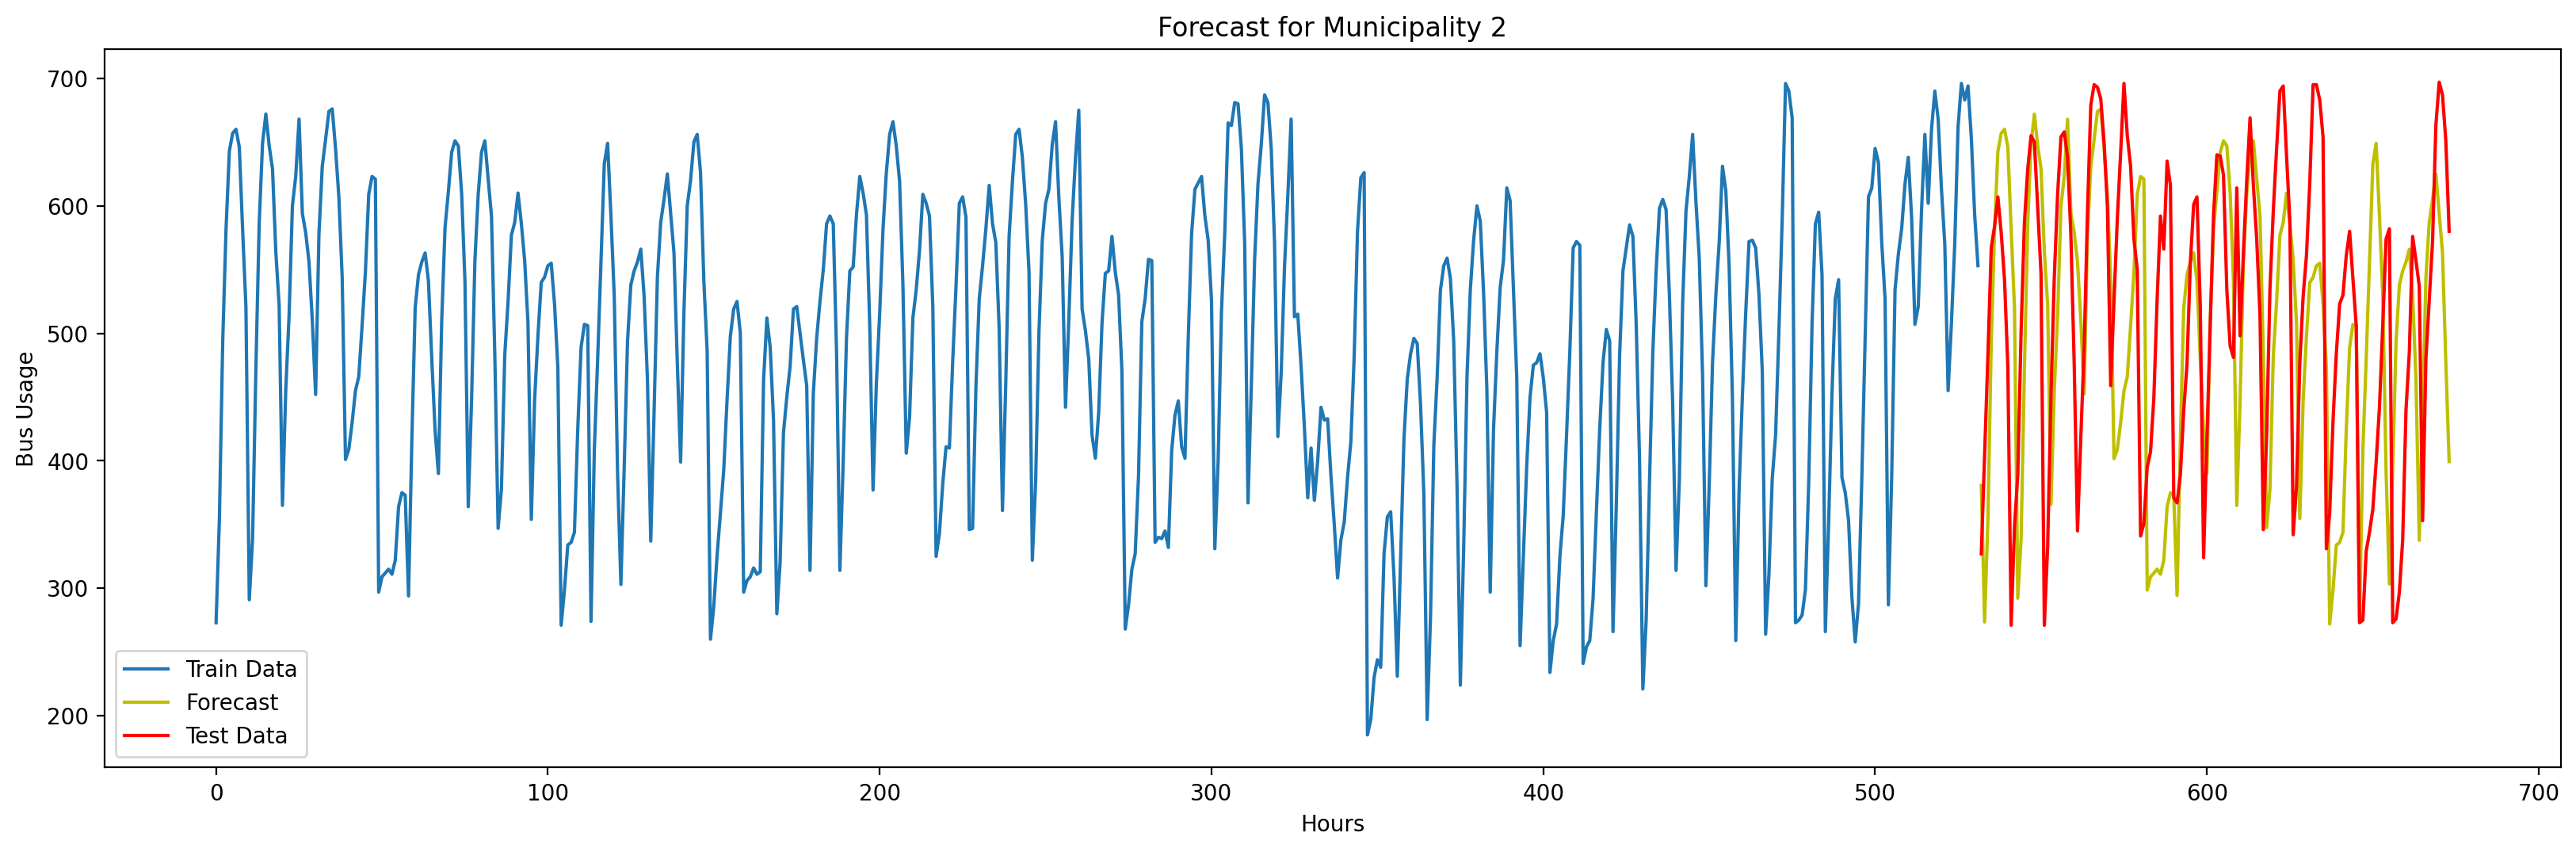

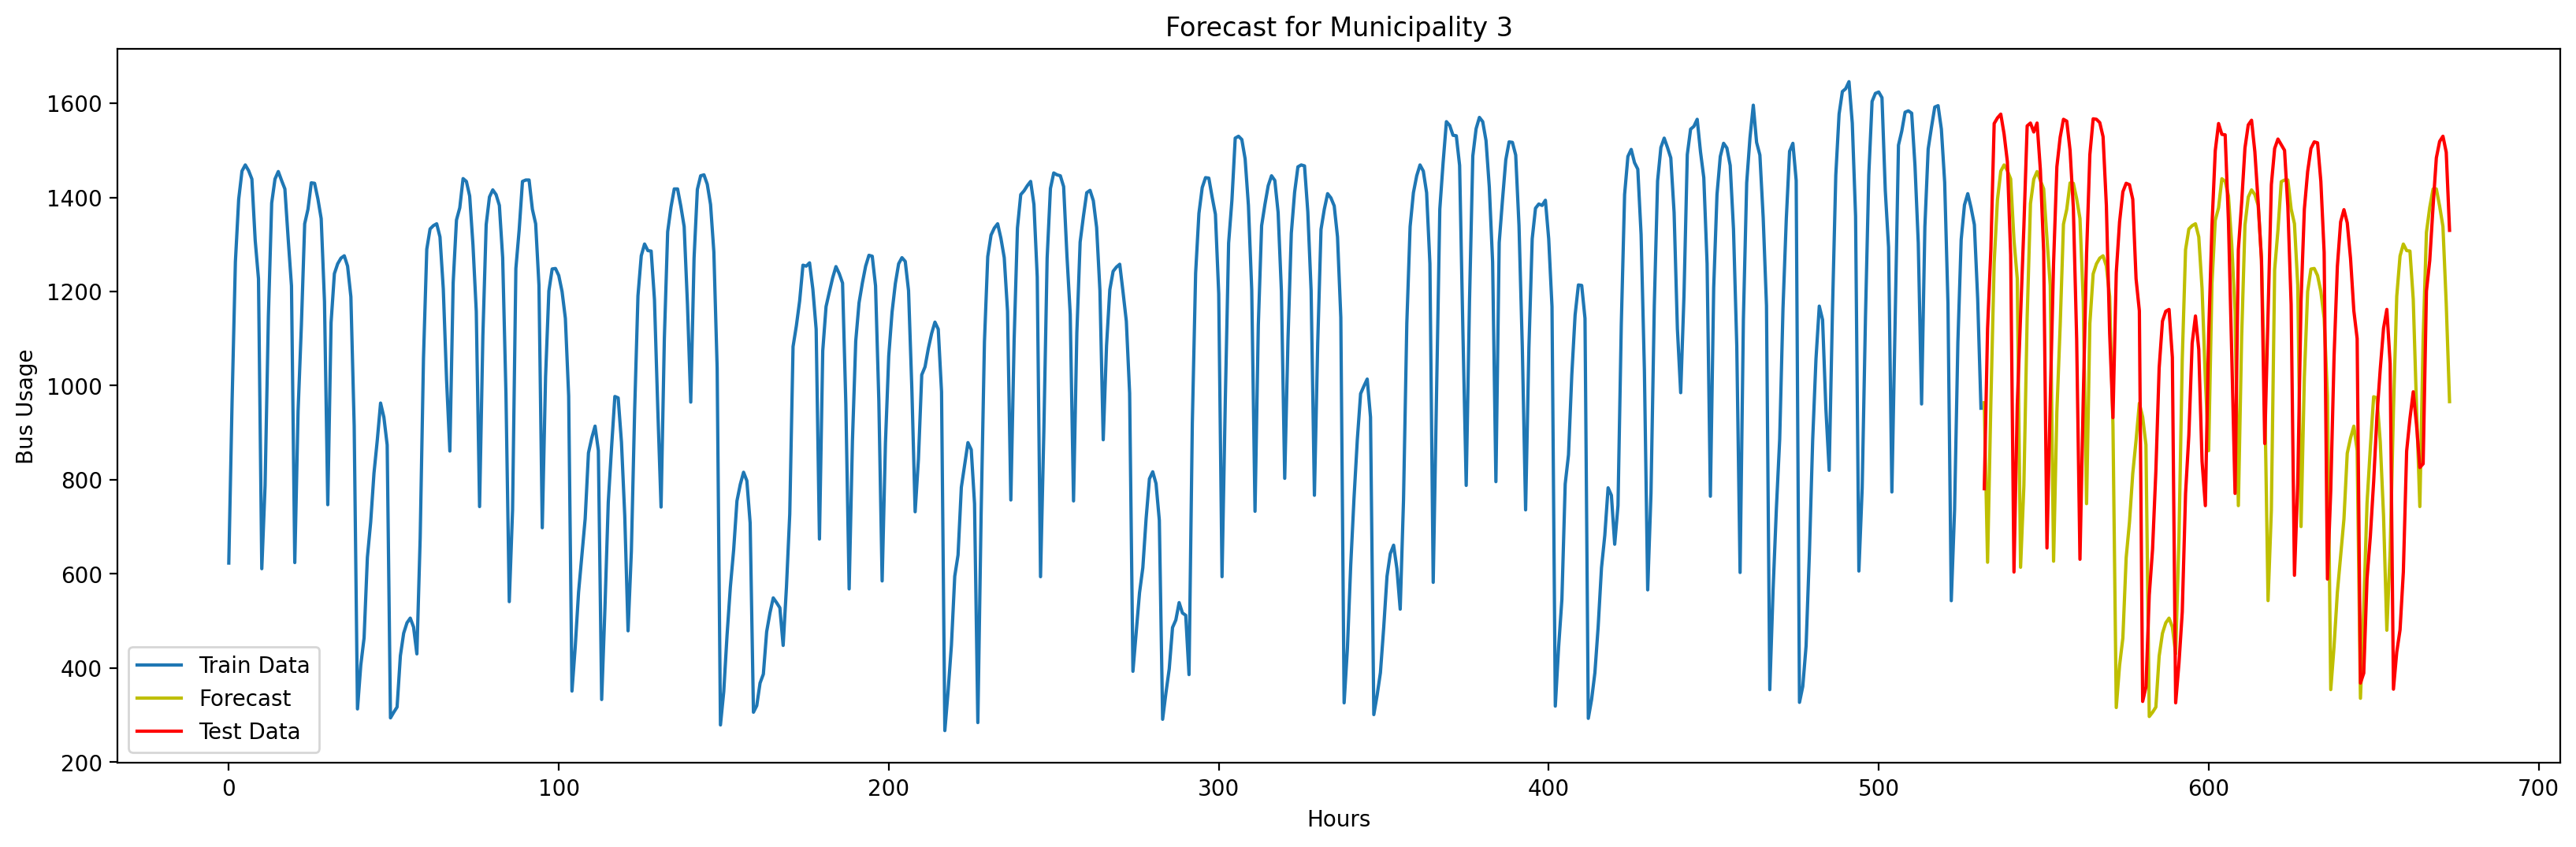

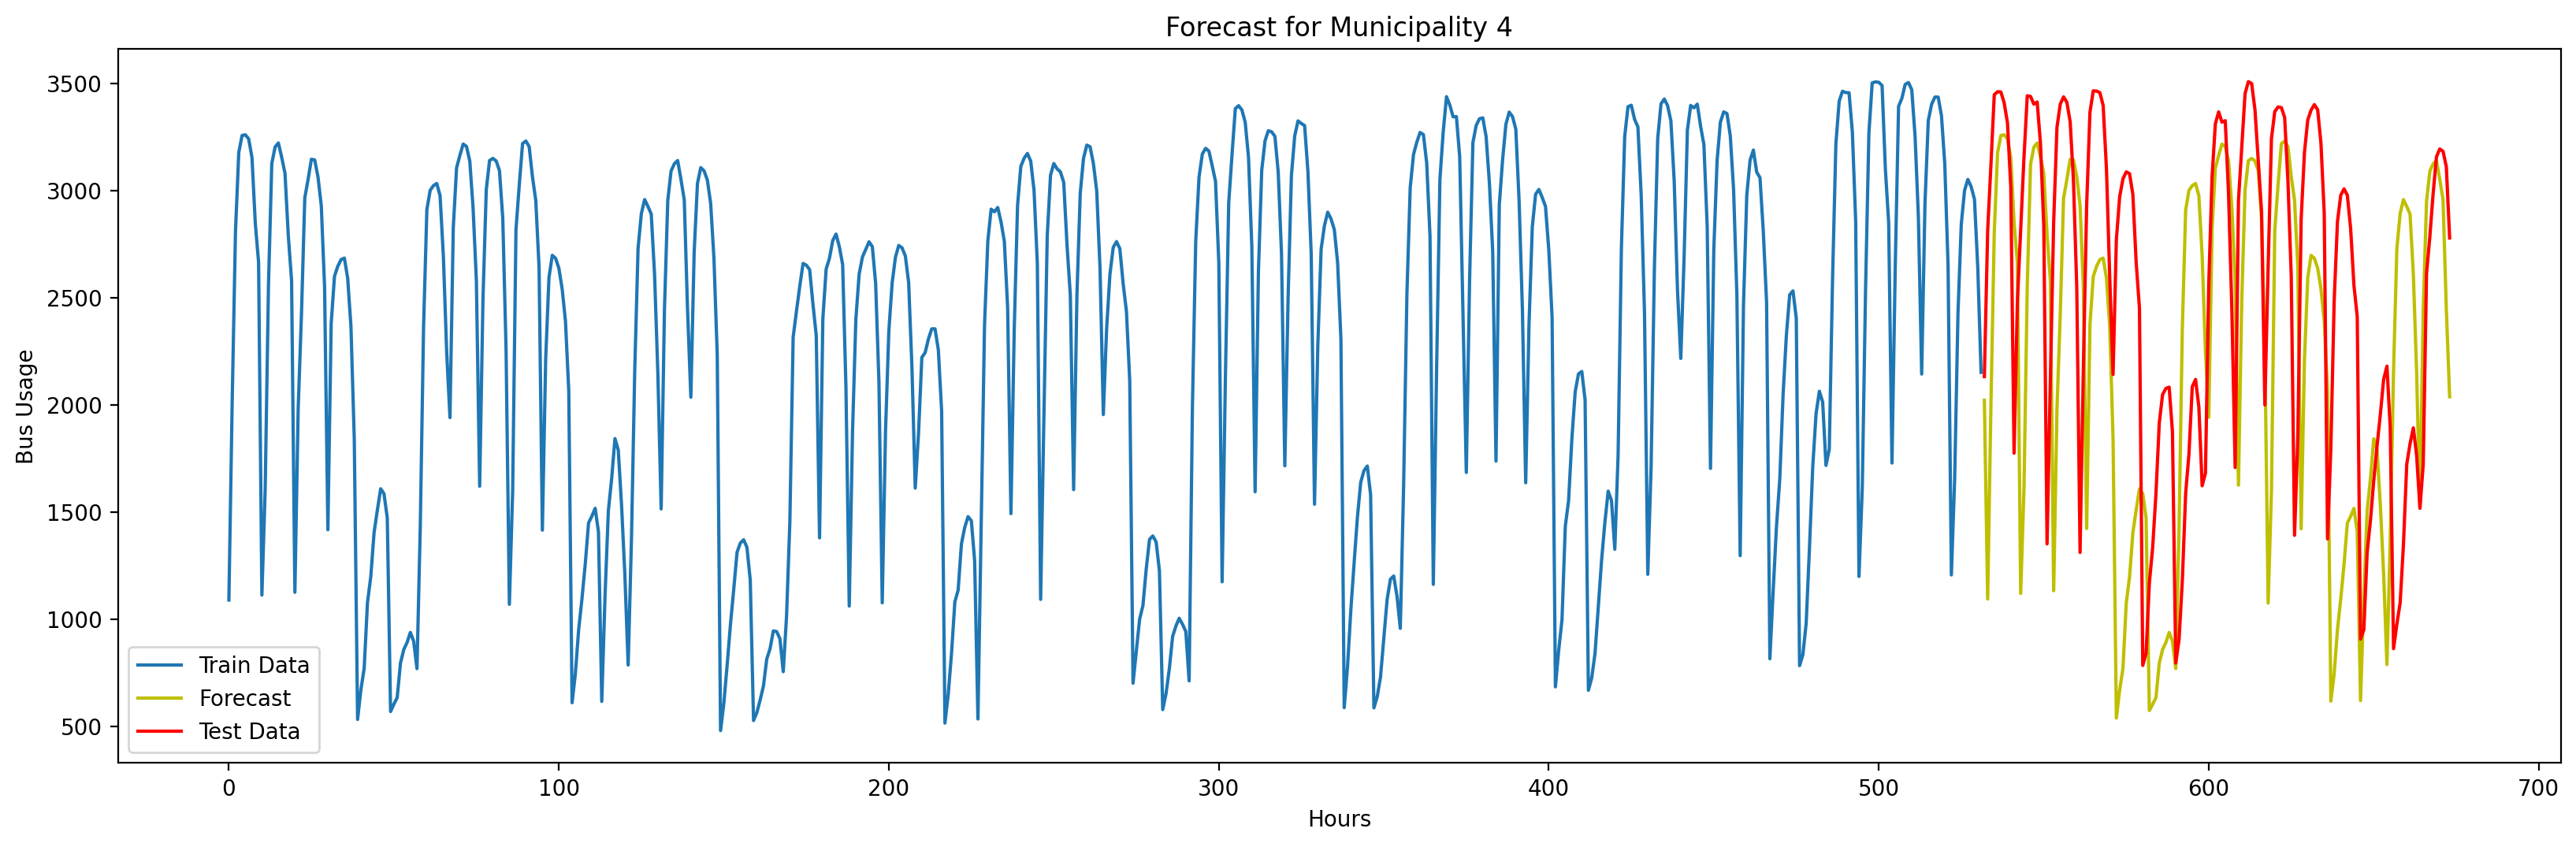

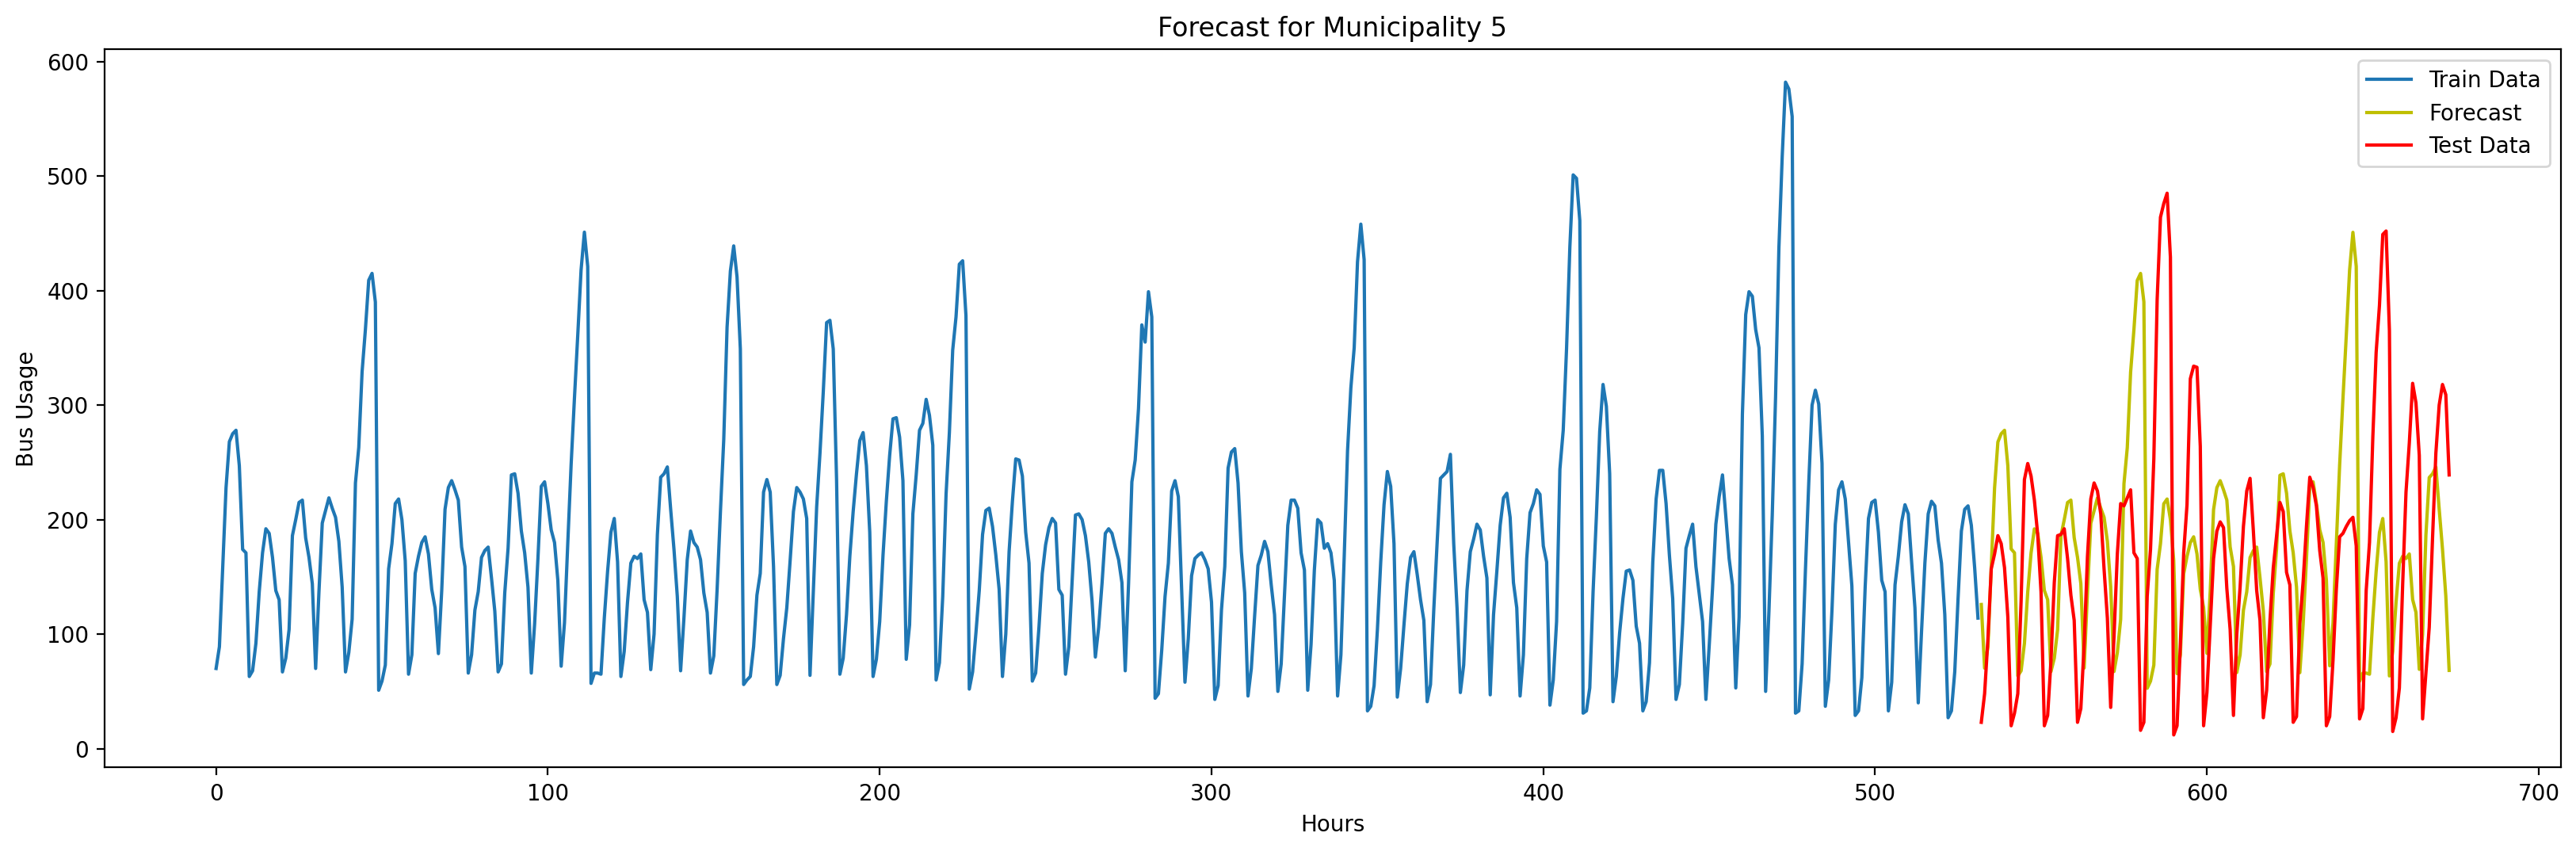

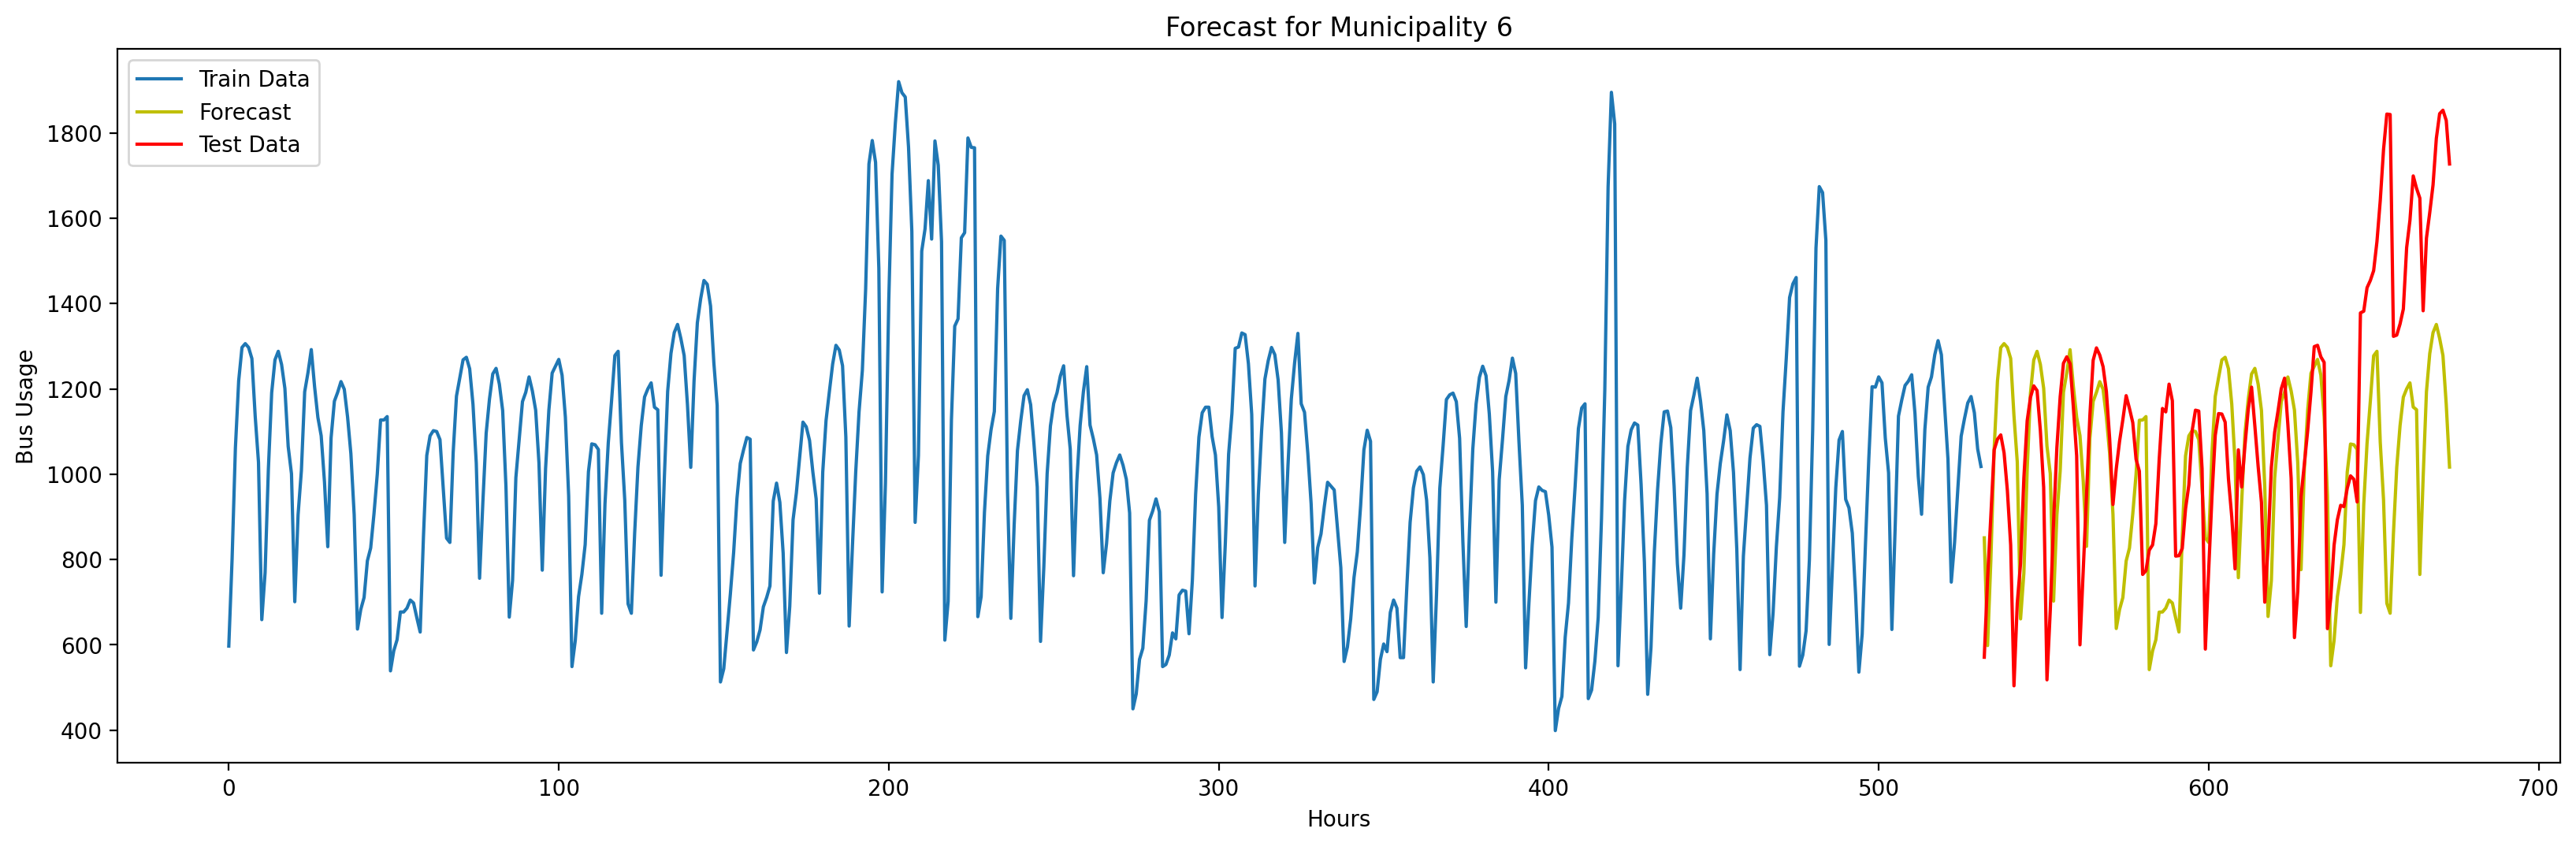

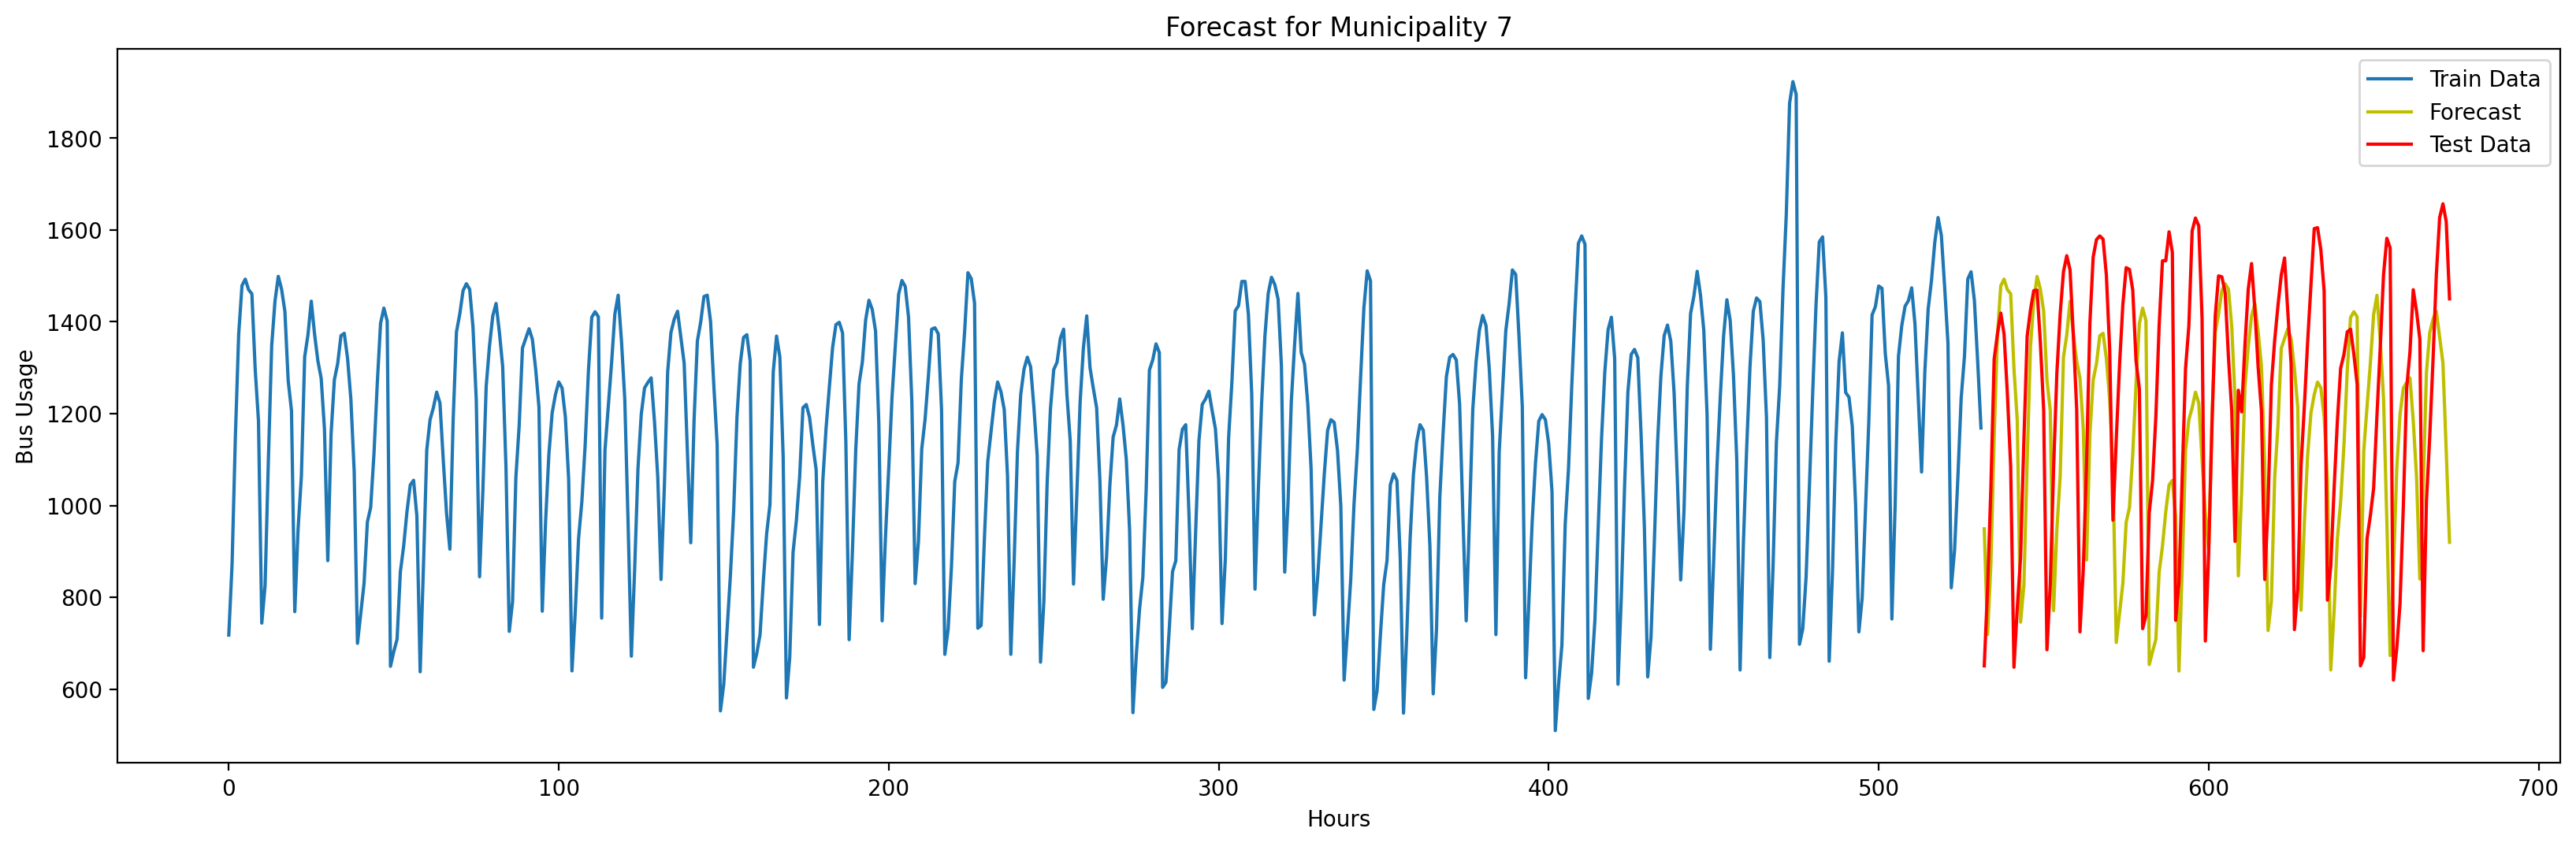

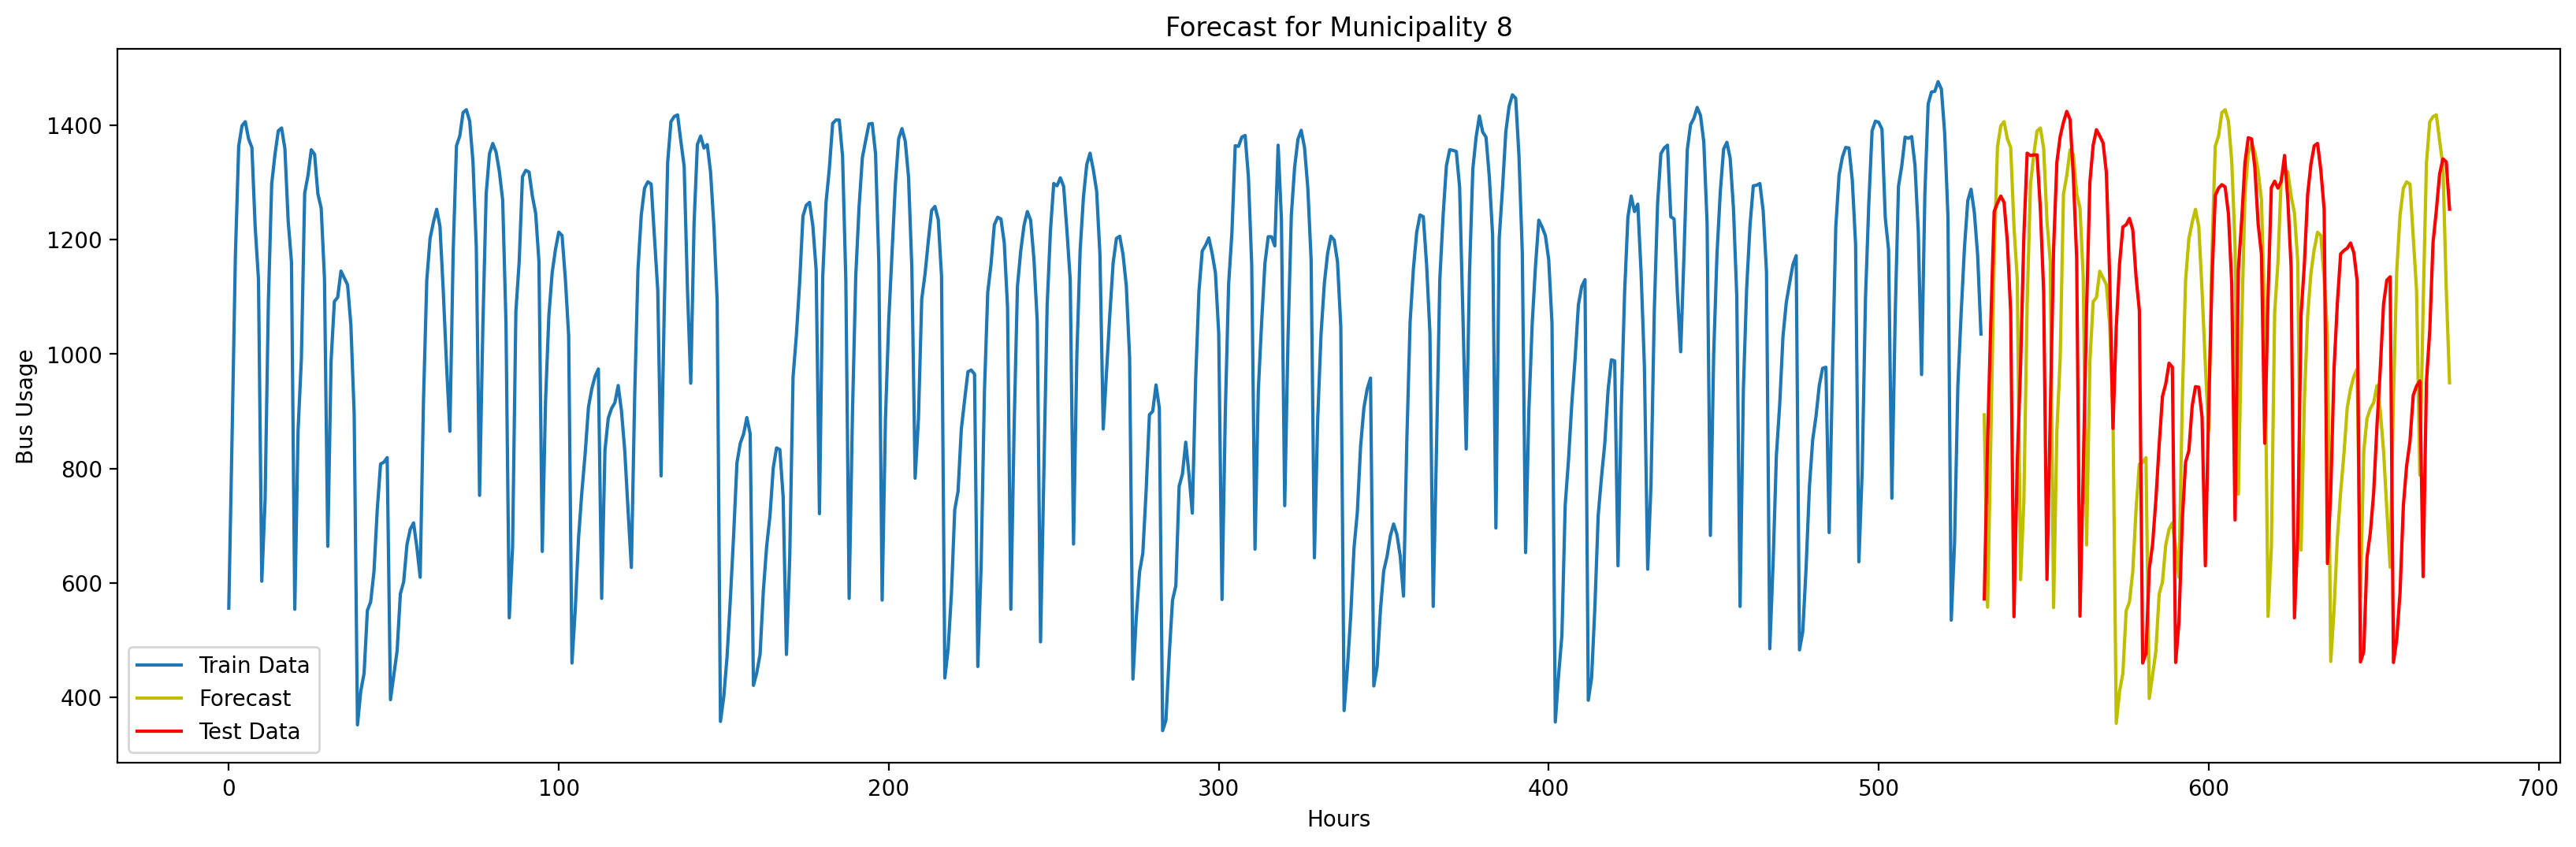

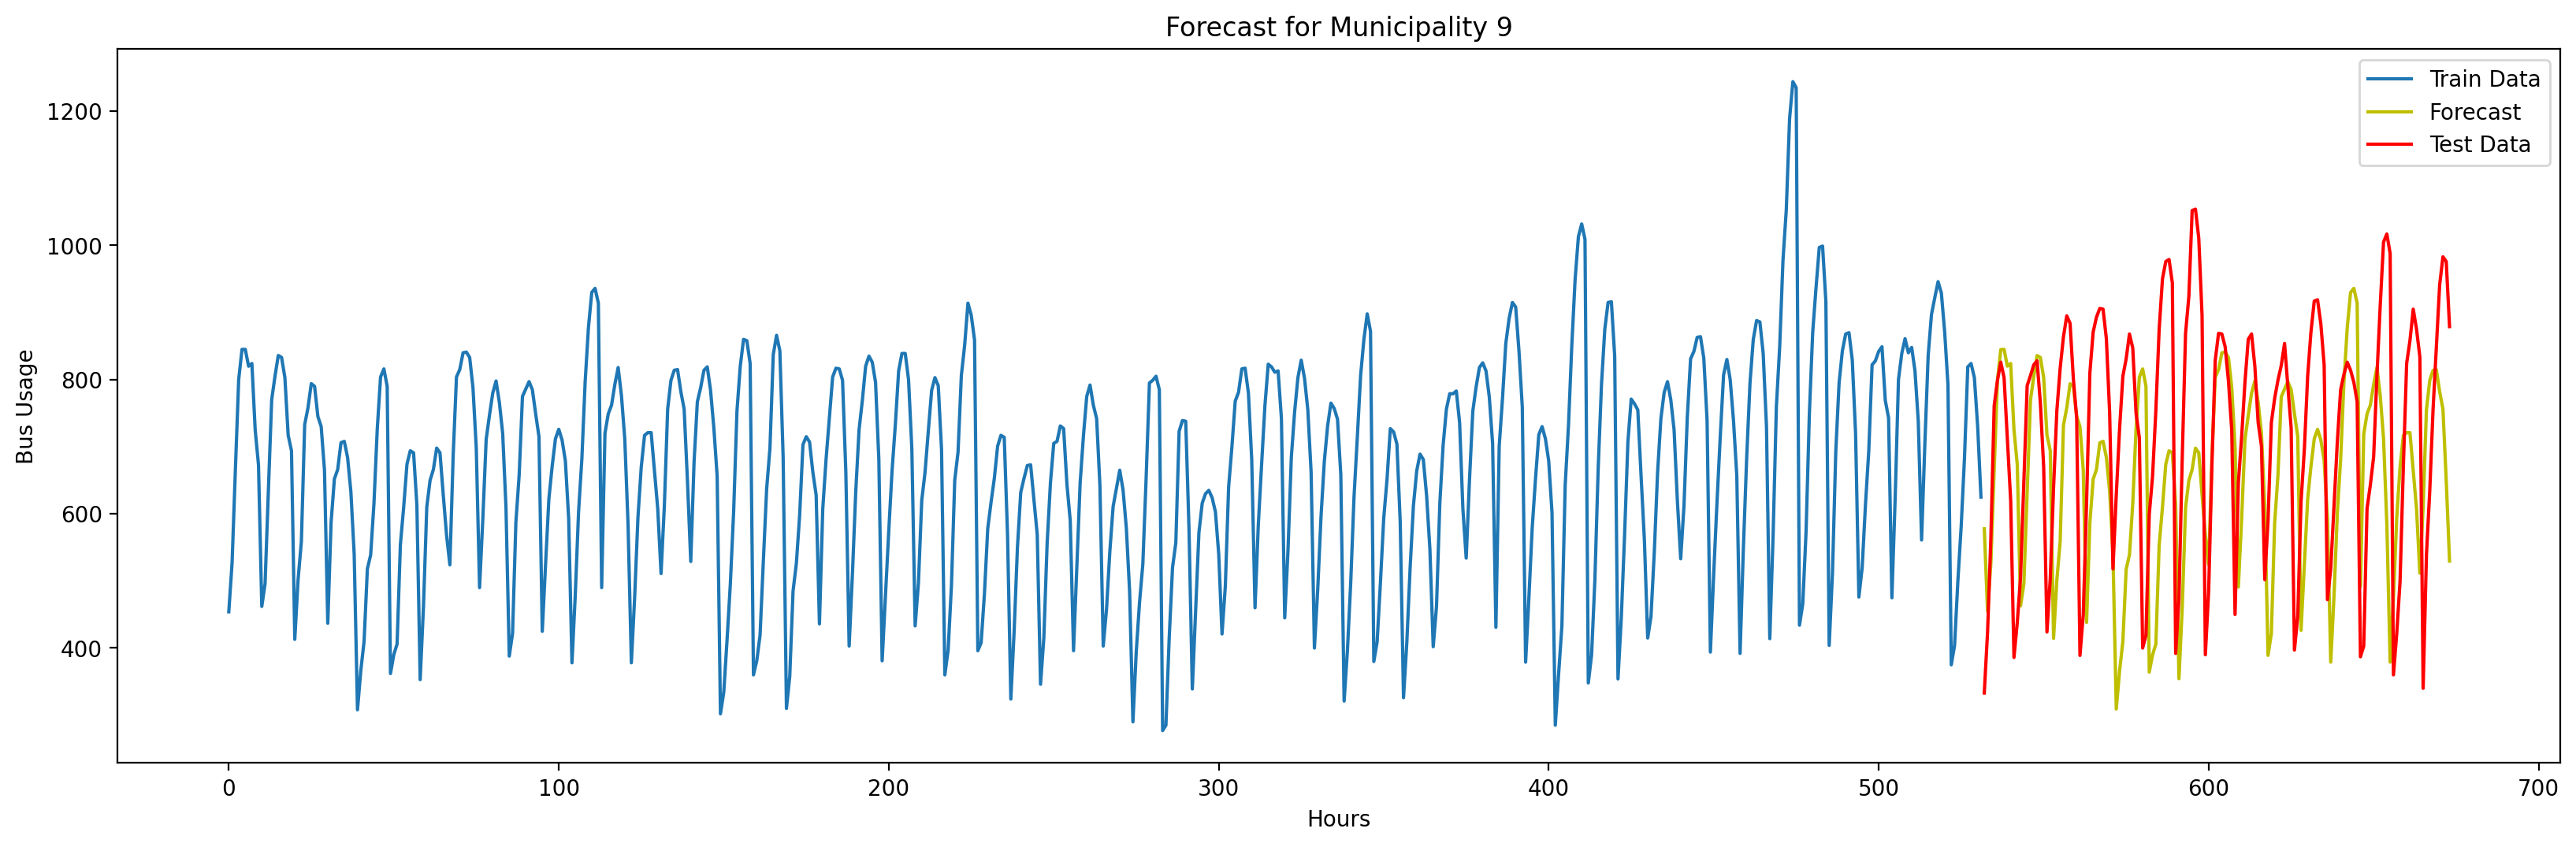

In [343]:
prediction_holder = {}
for i in range(10):
    model = ExponentialSmoothing(traindata_holder['traindata' + str(i)]["usage"], trend=None, seasonal=None, seasonal_periods=None)
    model = model.fit(optimized=True, remove_bias=False)
    if i == 0:
        print(model.summary())
    prediction_holder['prediction' + str(i)] = model.predict(start=testdata_holder['testdata' + str(i)]["usage"].index[0], end=testdata_holder['testdata' + str(i)]["usage"].index[-1])
    prediction_holder['prediction' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    testdata_holder['testdata' + str(i)].index += len(traindata_holder['traindata' + str(i)])
    plt.figure(figsize=(20, 6), dpi=200)
    plt.plot(traindata_holder['traindata' + str(i)]["usage"].index, traindata_holder['traindata' + str(i)]["usage"], label='Train Data')
    plt.plot(prediction_holder['prediction' + str(i)].index, prediction_holder['prediction' + str(i)], 'y-', label = 'Forecast')
    plt.plot(testdata_holder['testdata' + str(i)]["usage"].index, testdata_holder['testdata' + str(i)]["usage"], 'r-', label = 'Test Data')
    plt.xlabel('Hours'); plt.ylabel('Bus Usage'); plt.title('Forecast for Municipality %d' %i)
    plt.legend(loc="best")


# Explore RMSE, mean MAPE and mean MAE with Holtwinters ExponentialSmoothing

In [344]:
for i in range(10):
    print("For municipality %d, at forecast horizon %d, the RMSE is %f" % (i, Htest, get_rmse(testdata_holder['testdata' + str(i)][0:Htest]['usage'], prediction_holder['prediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAPE is %f" % (i, Htest, get_mape(testdata_holder['testdata' + str(i)][0:Htest]['usage'], prediction_holder['prediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAE is %f" % (i, Htest, get_mae(testdata_holder['testdata' + str(i)][0:Htest]['usage'], prediction_holder['prediction' + str(i)])))

For municipality 0, at forecast horizon 142, the RMSE is 340.977215
For municipality 0, at forecast horizon 142, the mean MAPE is 33.059348
For municipality 0, at forecast horizon 142, the mean MAE is 241.051667
For municipality 1, at forecast horizon 142, the RMSE is 120.568096
For municipality 1, at forecast horizon 142, the mean MAPE is 31.669364
For municipality 1, at forecast horizon 142, the mean MAE is 101.965273
For municipality 2, at forecast horizon 142, the RMSE is 132.629321
For municipality 2, at forecast horizon 142, the mean MAPE is 23.470310
For municipality 2, at forecast horizon 142, the mean MAE is 106.914343
For municipality 3, at forecast horizon 142, the RMSE is 402.216673
For municipality 3, at forecast horizon 142, the mean MAPE is 35.353522
For municipality 3, at forecast horizon 142, the mean MAE is 329.566853
For municipality 4, at forecast horizon 142, the RMSE is 976.265411
For municipality 4, at forecast horizon 142, the mean MAPE is 36.778480
For municipa

# Double_Exponential_Smoothing Forecasting

In [345]:
for i in range(10):
    traindata_holder['traindata' + str(i)].reset_index(inplace=True)
    traindata_holder['traindata' + str(i)].drop(['index'], axis=1, inplace=True)
    
    testdata_holder['testdata' + str(i)].reset_index(inplace=True)
    testdata_holder['testdata' + str(i)].drop(['index'], axis=1, inplace=True)

In [346]:
double_prediction_holder = {}
for i in range(10):
    double_prediction_holder['double_prediction' + str(i)], _ = double_exponential_smoothing(testdata_holder['testdata' + str(i)]["usage"][0:Htest].values, Htest, 0.3, 0.01, True)
    print("For municipality %d, at forecast horizon %d, the RMSE is %f" % (i, Htest, get_rmse(testdata_holder['testdata' + str(i)][0:H]['usage'], double_prediction_holder['double_prediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAPE is %f" % (i, Htest, get_mape(testdata_holder['testdata' + str(i)][0:H]['usage'], double_prediction_holder['double_prediction' + str(i)])))
    print("For municipality %d, at forecast horizon %d, the mean MAE is %f" % (i, Htest, get_mae(testdata_holder['testdata' + str(i)][0:H]['usage'], double_prediction_holder['double_prediction' + str(i)])))

For municipality 0, at forecast horizon 142, the RMSE is 3876.516224
For municipality 0, at forecast horizon 142, the mean MAPE is 587.009220
For municipality 0, at forecast horizon 142, the mean MAE is 3577.105936
For municipality 1, at forecast horizon 142, the RMSE is 1299.115483
For municipality 1, at forecast horizon 142, the mean MAPE is 368.630459
For municipality 1, at forecast horizon 142, the mean MAE is 1146.171189
For municipality 2, at forecast horizon 142, the RMSE is 1802.842422
For municipality 2, at forecast horizon 142, the mean MAPE is 336.600629
For municipality 2, at forecast horizon 142, the mean MAE is 1591.471356
For municipality 3, at forecast horizon 142, the RMSE is 7448.704352
For municipality 3, at forecast horizon 142, the mean MAPE is 701.067571
For municipality 3, at forecast horizon 142, the mean MAE is 6530.791652
For municipality 4, at forecast horizon 142, the RMSE is 14760.606032
For municipality 4, at forecast horizon 142, the mean MAPE is 636.9091

# Double_Exponential_Smoothing Grid Check Hyperparameters alpha,beta

In [347]:
param_grid = {}

param_grid['alpha'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
param_grid['beta'] = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

'''
for i in range(10):
    for alpha in param_grid['alpha']:
        for beta in param_grid['beta']:
            testdata_holder['testdata' + str(i) + str(alpha) + str(beta)] = testdata_holder['testdata' + str(i)]
'''

for i in range(10):
    for alpha in param_grid['alpha']:
        for beta in param_grid['beta']:
            double_prediction_holder['double_prediction' + str(i) + str(alpha) + str(beta)], _ = double_exponential_smoothing(testdata_holder['testdata' + str(i)]["usage"][0:Htest].values, Htest, alpha, beta, True)
            print("For municipality %d,for alpha= %f beta= %f, at forecast horizon %d, the RMSE is %f" % (i, alpha, beta, Htest, get_rmse(testdata_holder['testdata' + str(i)][0:H]['usage'], double_prediction_holder['double_prediction' + str(i) + str(alpha) + str(beta)])))

For municipality 0,for alpha= 0.100000 beta= 0.100000, at forecast horizon 142, the RMSE is 1934.365725
For municipality 0,for alpha= 0.100000 beta= 0.200000, at forecast horizon 142, the RMSE is 610.785936
For municipality 0,for alpha= 0.100000 beta= 0.300000, at forecast horizon 142, the RMSE is 1798.028767
For municipality 0,for alpha= 0.100000 beta= 0.400000, at forecast horizon 142, the RMSE is 1342.327531
For municipality 0,for alpha= 0.100000 beta= 0.500000, at forecast horizon 142, the RMSE is 780.840559
For municipality 0,for alpha= 0.100000 beta= 0.600000, at forecast horizon 142, the RMSE is 2983.382364
For municipality 0,for alpha= 0.100000 beta= 0.700000, at forecast horizon 142, the RMSE is 4864.396869
For municipality 0,for alpha= 0.100000 beta= 0.800000, at forecast horizon 142, the RMSE is 5833.693649
For municipality 0,for alpha= 0.100000 beta= 0.900000, at forecast horizon 142, the RMSE is 5707.473541
For municipality 0,for alpha= 0.200000 beta= 0.100000, at forecast

For municipality 3,for alpha= 0.600000 beta= 0.800000, at forecast horizon 142, the RMSE is 9113.019659
For municipality 3,for alpha= 0.600000 beta= 0.900000, at forecast horizon 142, the RMSE is 9906.493996
For municipality 3,for alpha= 0.700000 beta= 0.100000, at forecast horizon 142, the RMSE is 2383.173753
For municipality 3,for alpha= 0.700000 beta= 0.200000, at forecast horizon 142, the RMSE is 1626.591517
For municipality 3,for alpha= 0.700000 beta= 0.300000, at forecast horizon 142, the RMSE is 646.826588
For municipality 3,for alpha= 0.700000 beta= 0.400000, at forecast horizon 142, the RMSE is 2895.747518
For municipality 3,for alpha= 0.700000 beta= 0.500000, at forecast horizon 142, the RMSE is 5019.075358
For municipality 3,for alpha= 0.700000 beta= 0.600000, at forecast horizon 142, the RMSE is 6814.375488
For municipality 3,for alpha= 0.700000 beta= 0.700000, at forecast horizon 142, the RMSE is 8239.002894
For municipality 3,for alpha= 0.700000 beta= 0.800000, at forecas

For municipality 6,for alpha= 0.400000 beta= 0.900000, at forecast horizon 142, the RMSE is 3521.494196
For municipality 6,for alpha= 0.500000 beta= 0.100000, at forecast horizon 142, the RMSE is 2093.762265
For municipality 6,for alpha= 0.500000 beta= 0.200000, at forecast horizon 142, the RMSE is 2122.885462
For municipality 6,for alpha= 0.500000 beta= 0.300000, at forecast horizon 142, the RMSE is 1766.184362
For municipality 6,for alpha= 0.500000 beta= 0.400000, at forecast horizon 142, the RMSE is 1066.615186
For municipality 6,for alpha= 0.500000 beta= 0.500000, at forecast horizon 142, the RMSE is 565.703432
For municipality 6,for alpha= 0.500000 beta= 0.600000, at forecast horizon 142, the RMSE is 1485.949041
For municipality 6,for alpha= 0.500000 beta= 0.700000, at forecast horizon 142, the RMSE is 3003.216107
For municipality 6,for alpha= 0.500000 beta= 0.800000, at forecast horizon 142, the RMSE is 4711.013220
For municipality 6,for alpha= 0.500000 beta= 0.900000, at forecas

For municipality 9,for alpha= 0.700000 beta= 0.400000, at forecast horizon 142, the RMSE is 459.348917
For municipality 9,for alpha= 0.700000 beta= 0.500000, at forecast horizon 142, the RMSE is 1067.449198
For municipality 9,for alpha= 0.700000 beta= 0.600000, at forecast horizon 142, the RMSE is 2661.621467
For municipality 9,for alpha= 0.700000 beta= 0.700000, at forecast horizon 142, the RMSE is 4136.762165
For municipality 9,for alpha= 0.700000 beta= 0.800000, at forecast horizon 142, the RMSE is 5319.306392
For municipality 9,for alpha= 0.700000 beta= 0.900000, at forecast horizon 142, the RMSE is 6188.396911
For municipality 9,for alpha= 0.800000 beta= 0.100000, at forecast horizon 142, the RMSE is 1193.354280
For municipality 9,for alpha= 0.800000 beta= 0.200000, at forecast horizon 142, the RMSE is 1391.294943
For municipality 9,for alpha= 0.800000 beta= 0.300000, at forecast horizon 142, the RMSE is 835.132749
For municipality 9,for alpha= 0.800000 beta= 0.400000, at forecast

### For municipality 0 optimum parameters are : RMSE: 506.1   alpha: 0.8 beta: 0.6
### For municipality 1 optimum parameters are : RMSE: 90.5    alpha: 0.6 beta: 0.5
### For municipality 2 optimum parameters are : RMSE: 153     alpha: 0.3 beta: 0.7
### For municipality 3 optimum parameters are : RMSE: 737     alpha: 0.9 beta: 0.2
### For municipality 4 optimum parameters are : RMSE: 902.2   alpha: 0.6 beta: 0.3
### For municipality 5 optimum parameters are : RMSE: 136.93  alpha: 0.1 beta: 0.2
### For municipality 6 optimum parameters are : RMSE: 536.67  alpha: 0.8 beta: 0.3
### For municipality 7 optimum parameters are : RMSE: 574.3   alpha: 0.6 beta: 0.4
### For municipality 8 optimum parameters are : RMSE: 320.0   alpha: 0.7 beta: 0.4
### For municipality 9 optimum parameters are : RMSE: 503.2   alpha: 0.4 beta: 0.8
